# Schilderijen classificeren — Alle schilders

In deze notebook splitsen we de dataset (per schilder) in **train/val/test** en evalueren we een **simple ConvNet** op vier klassen:

- Mondriaan  
- Picasso  
- Rembrandt  
- Rubens  

Omdat de dataset **sterk ongebalanceerd** is (Picasso heeft veel meer voorbeelden), rapporteren we naast accuracy ook de **macro F1-score** en bekijken we de **confusion matrix**.


## 1. Dataset voorbereiden (train/val/test)

De map `schilderijen/` bevat per schilder een submap met afbeeldingen.  
We splitsen **per schilder** in train/val/test zodat elke klasse in alle splits aanwezig is.

> **Opmerking:** door de onbalans (verschillend aantal afbeeldingen per schilder) krijgt het model tijdens training veel meer Picasso-voorbeelden, wat de evaluatie beïnvloedt.

### 1.1 Split-script
De volgende code maakt de structuur:

```
datasets/alle_schilders/
  train/<schilder>/
  val/<schilder>/
  test/<schilder>/
```


In [1]:
# Split alle schilders uit ./schilderijen naar train/val/test in:
# ./datasets/alle_schilders/{train,val,test}/{SchilderNaam_X}/...

from pathlib import Path
import random
import shutil


# Instellingen
SEED = 42
TRAIN_RATIO = 0.70
VAL_RATIO   = 0.15
TEST_RATIO  = 0.15

MODE = "copy"  # "copy" of "move"


# Project root vinden
cwd = Path.cwd()

project_root = None
for p in [cwd] + list(cwd.parents):
    if (p / "schilderijen").exists() and (p / "datasets").exists():
        project_root = p
        break

if project_root is None:
    raise FileNotFoundError(
        "Kon project root niet vinden. "
        "Ik verwacht 'schilderijen' en 'datasets' in dezelfde map."
    )

src_root = project_root / "schilderijen"
dst_root = project_root / "datasets" / "alle_schilders"

print("Source:", src_root)
print("Destination:", dst_root)

random.seed(SEED)

# Helpers

def list_images(folder: Path):
    return [p for p in folder.rglob("*") if p.is_file()]

def ensure_dir(p: Path):
    p.mkdir(parents=True, exist_ok=True)

def safe_copy_or_move(src: Path, dst: Path):
    if dst.exists():
        stem, suf = src.stem, src.suffix
        i = 1
        while True:
            candidate = dst.with_name(f"{stem}_{i}{suf}")
            if not candidate.exists():
                dst = candidate
                break
            i += 1

    ensure_dir(dst.parent)
    if MODE == "move":
        shutil.move(src, dst)
    else:
        shutil.copy2(src, dst)

def split_counts(n: int):
    n_train = int(n * TRAIN_RATIO)
    n_val   = int(n * VAL_RATIO)
    n_test  = n - n_train - n_val

    if n >= 3:
        if n_val == 0: n_val = 1
        if n_test == 0: n_test = 1
        n_train = n - n_val - n_test
    else:
        n_train, n_val, n_test = n, 0, 0

    return n_train, n_val, n_test

# Output structuur
for split in ["train", "val", "test"]:
    ensure_dir(dst_root / split)


# Split per schilder
painter_dirs = sorted([p for p in src_root.iterdir() if p.is_dir()])

print("Schilders:", [p.name for p in painter_dirs])

for painter_dir in painter_dirs:
    painter = painter_dir.name
    imgs = list_images(painter_dir)
    n = len(imgs)

    if n == 0:
        print(f"Geen images voor {painter}, overslaan")
        continue

    random.shuffle(imgs)
    n_train, n_val, n_test = split_counts(n)

    train_files = imgs[:n_train]
    val_files   = imgs[n_train:n_train + n_val]
    test_files  = imgs[n_train + n_val:n_train + n_val + n_test]

    for f in train_files:
        safe_copy_or_move(f, dst_root / "train" / painter / f.name)
    for f in val_files:
        safe_copy_or_move(f, dst_root / "val" / painter / f.name)
    for f in test_files:
        safe_copy_or_move(f, dst_root / "test" / painter / f.name)

    print(
        f"{painter}: total={n} | "
        f"train={len(train_files)} val={len(val_files)} test={len(test_files)}"
    )

print("\n Klaar! Dataset aangemaakt in:", dst_root)


Source: c:\Users\Moustafa\Documents\deep learning\opdracht schilderijen classificeren\schilderijen
Destination: c:\Users\Moustafa\Documents\deep learning\opdracht schilderijen classificeren\datasets\alle_schilders
Schilders: ['Mondriaan', 'Picasso', 'Rembrandt', 'Rubens']
Mondriaan: total=330 | train=230 val=49 test=51
Picasso: total=1529 | train=1070 val=229 test=230
Rembrandt: total=243 | train=170 val=36 test=37
Rubens: total=682 | train=477 val=102 test=103

 Klaar! Dataset aangemaakt in: c:\Users\Moustafa\Documents\deep learning\opdracht schilderijen classificeren\datasets\alle_schilders


### 1.2 Resultaat van de split (voorbeeld telling)

Na het splitten ziet de verdeling er als volgt uit:

- **Mondriaan:** total=330 | train=230 | val=49 | test=51  
- **Picasso:** total=1529 | train=1070 | val=229 | test=230  
- **Rembrandt:** total=243 | train=170 | val=36 | test=37  
- **Rubens:** total=682 | train=477 | val=102 | test=103  

Dit bevestigt dat de dataset **niet gebalanceerd** is (Picasso is dominant).


De simpele convent werd getraind op de Vlaamse Super Computer. Hieronder zal ik de resultaten weergeven en bespreken

## 2. Simple ConvNet (baseline)

We trainen een eenvoudig convolutioneel netwerk als baseline. Daarna vergelijken we twee varianten:

1. **Zonder data augmentation**
2. **Met data augmentation** (flip/rotatie/zoom)

We evalueren op de testset met **accuracy**, **classification report** en **confusion matrix**.


### 2.1 Zonder data augmentation

### 2.1 Zonder data augmentation

**Instelling:** geen augmentatie, geen class weights. Dit is een pure baseline om te zien hoe ver een simpel ConvNet komt op de ongebalanceerde dataset.

**Verwachting:** hogere kans op **overfitting** en een bias richting de grootste klasse (Picasso).


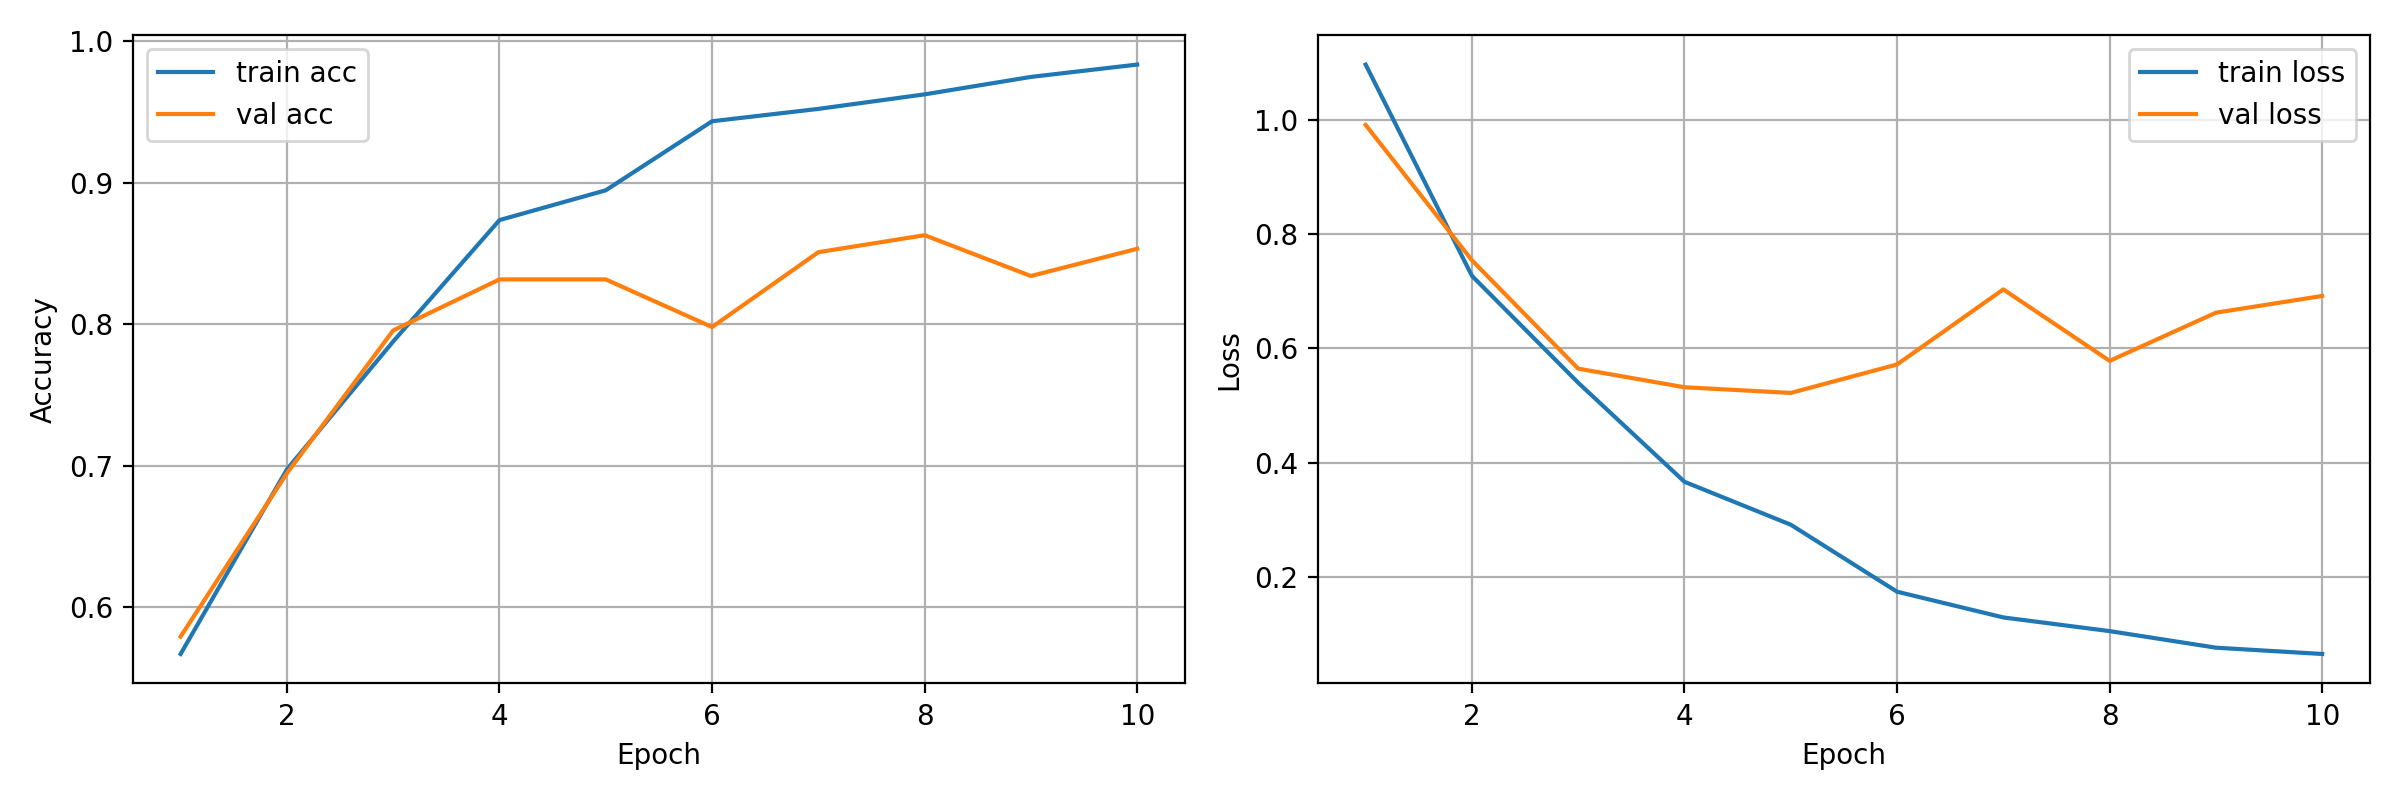

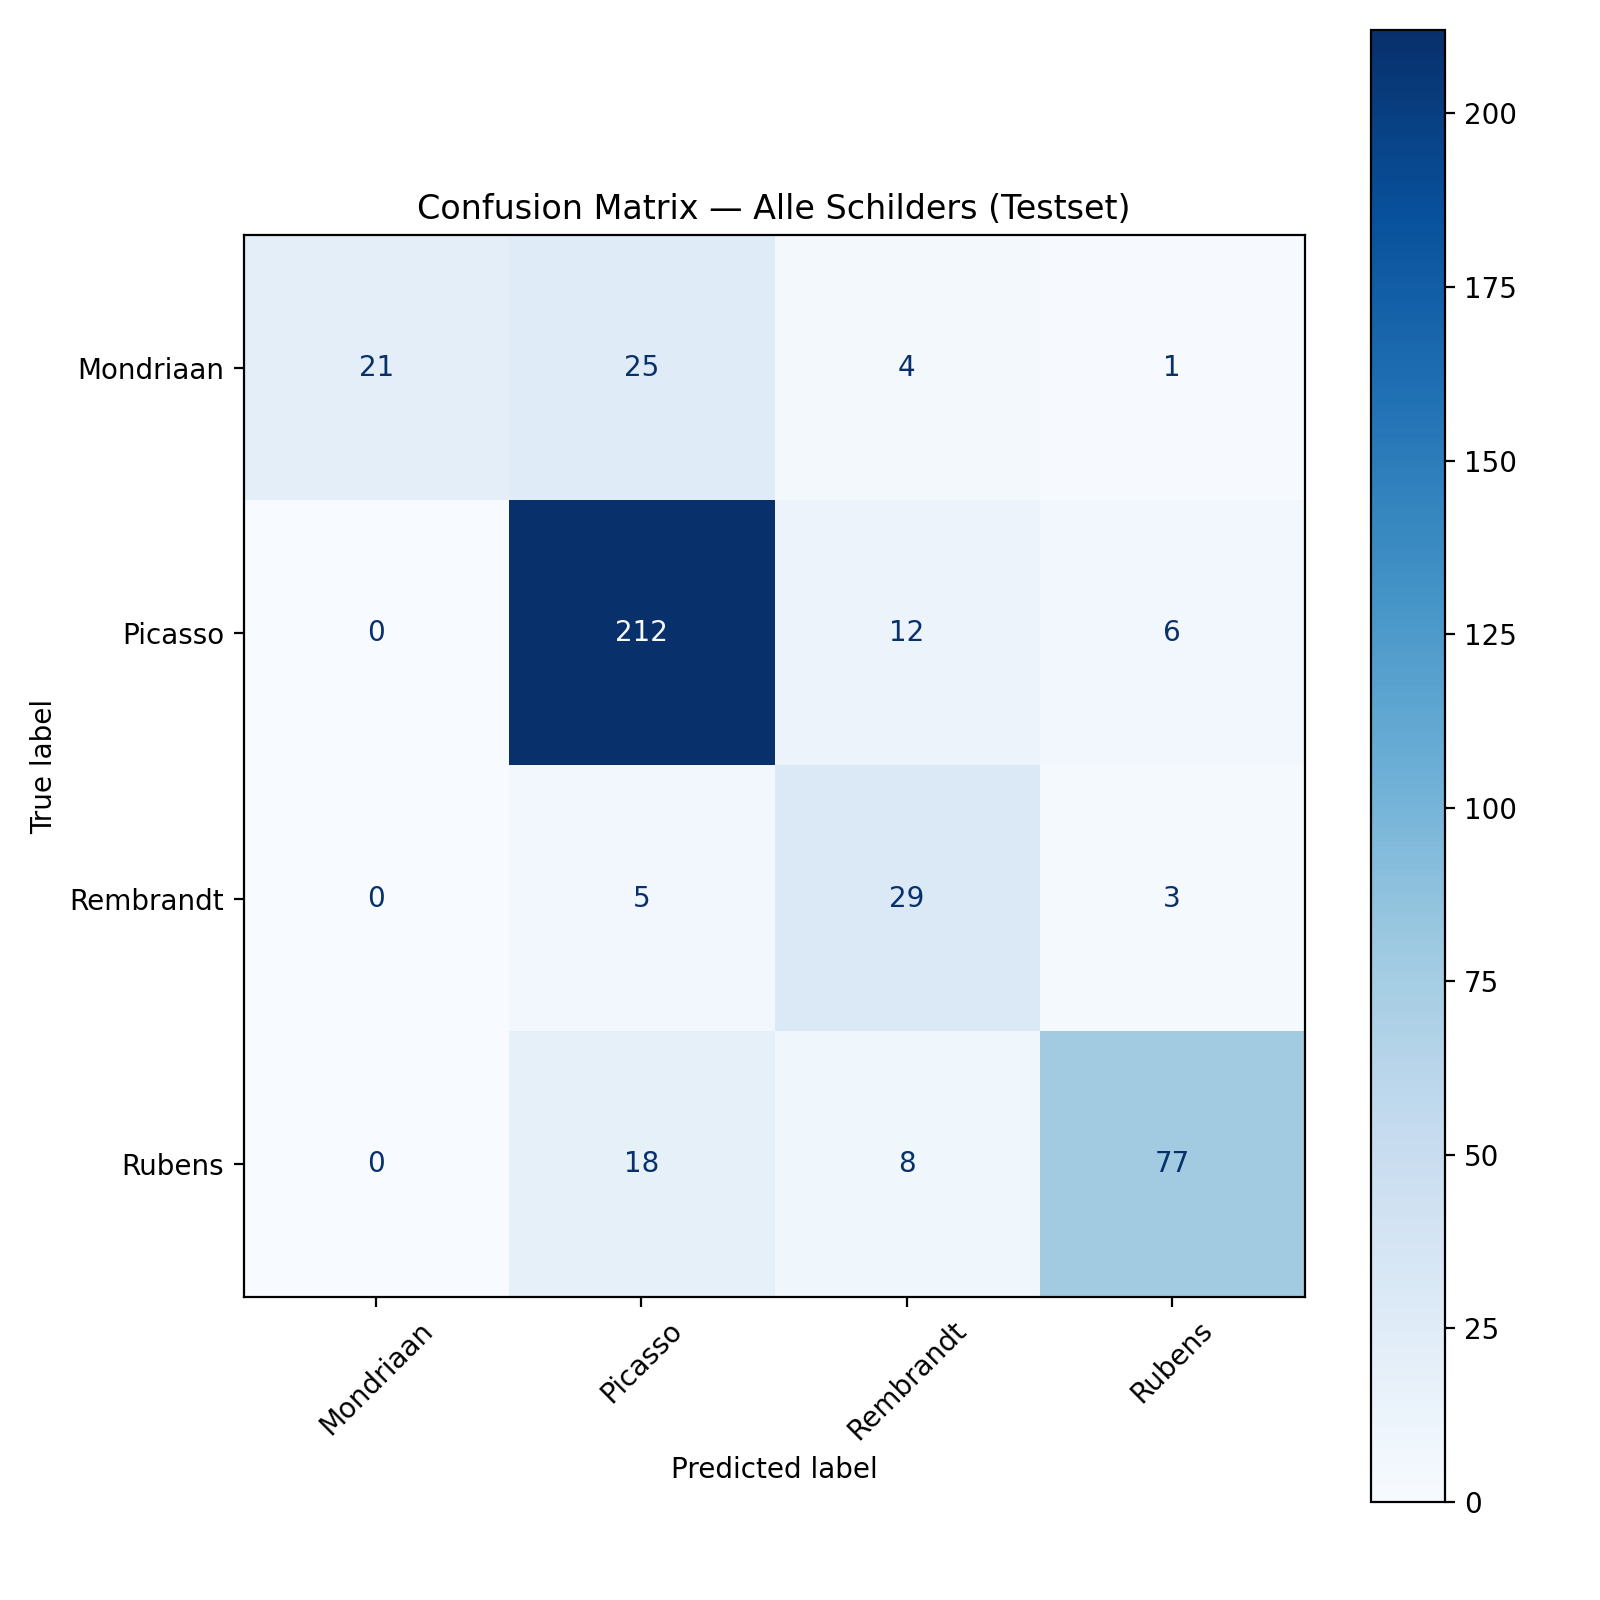

test_loss=0.6146371364593506
test_accuracy=0.805225670337677

**Testresultaten (zonder augmentation):**

- test_loss = 0.6146  
- test_accuracy = 0.8052  

**Kernobservaties:**
- Train accuracy liep op tot bijna 1.0 terwijl val accuracy duidelijk lager bleef → **overfitting**.
- Het model presteert zeer goed op de dominante klasse **Picasso**, maar minder goed op de kleinere klassen.
- De macro F1-score was lager dan de weighted F1-score, wat wijst op zwakkere prestaties op minderheidsklassen.


**Besluit (zonder augmentation)**  
Het simple ConvNet behaalt een redelijke accuracy, maar vertoont duidelijke **overfitting** en een **bias** richting de dominante klasse (Picasso). Minderheidsklassen (zoals Mondriaan/Rembrandt) worden relatief vaker fout geclassificeerd, waardoor accuracy alleen een onvolledige samenvatting geeft. Dit baseline-model is dus beperkt in generalisatie op deze dataset.


### 2.2 Met data augmentation

**Instelling:** we voegen data augmentation toe (random flip/rotation/zoom). Dit vergroot de variatie in de trainingdata en helpt het model robuustere kenmerken te leren.

**Verwachting:** minder overfitting en betere prestaties op minderheidsklassen.


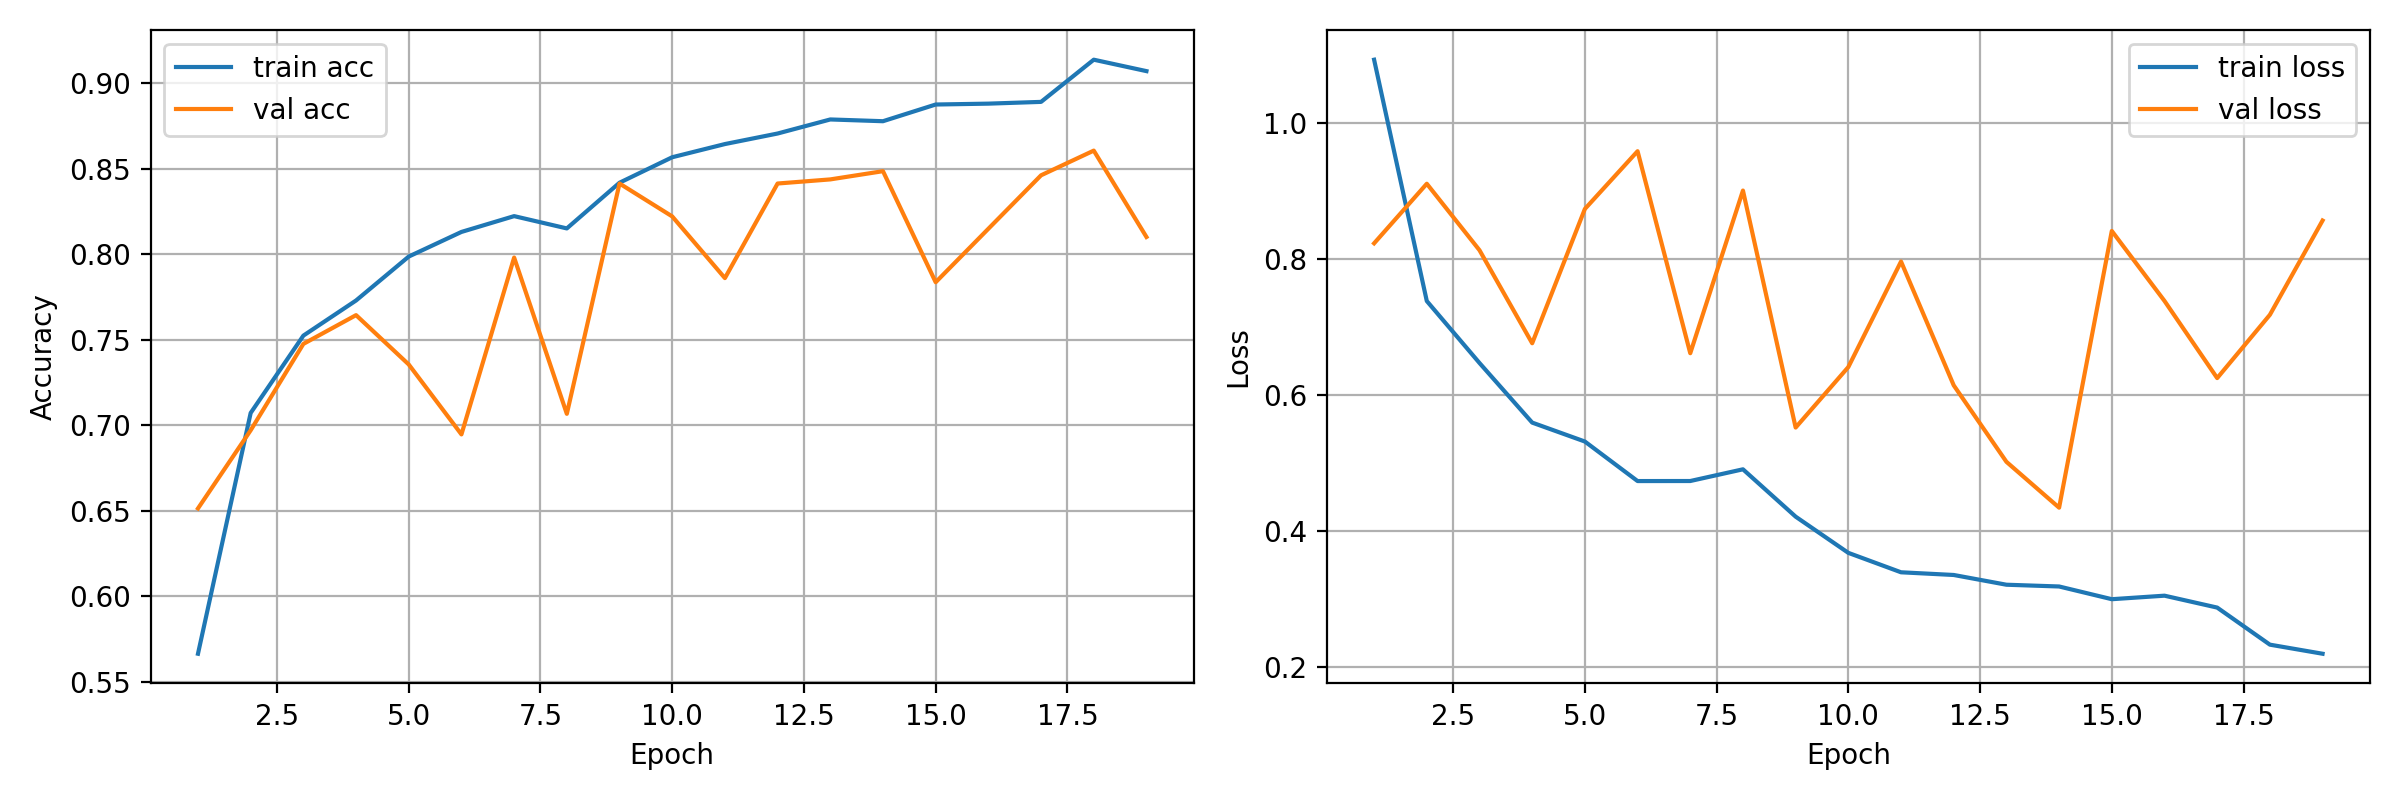

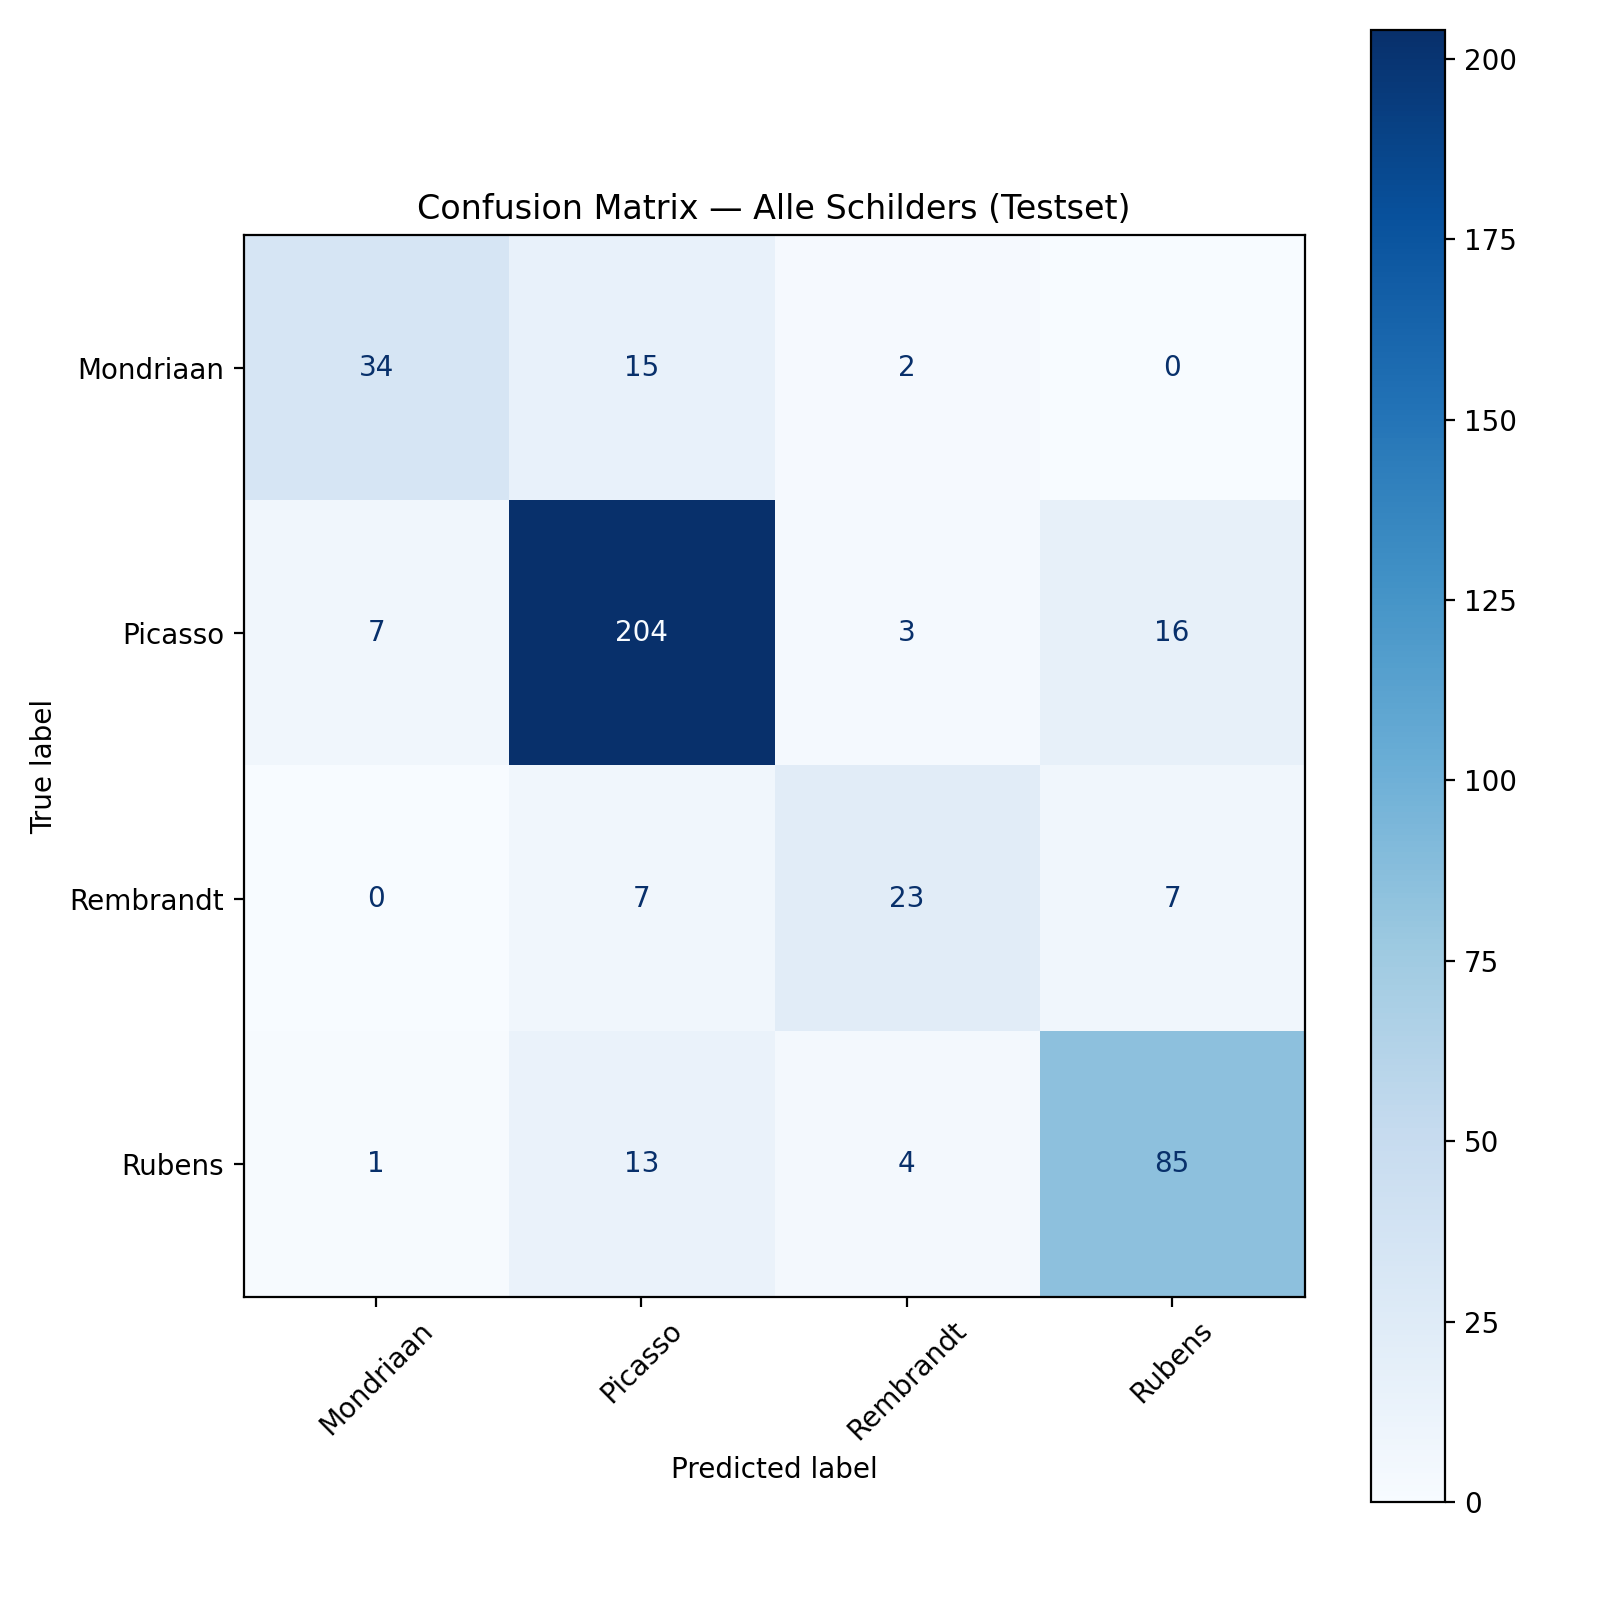

**Beste train/val metrics (met augmentation):**

- Best val_loss epoch: 14  
  - train_loss = 0.3180 | val_loss = 0.4339  
  - train_acc  = 0.8778 | val_acc  = 0.8486  

- Best val_accuracy epoch: 18  
  - train_loss = 0.2325 | val_loss = 0.7176  
  - train_acc  = 0.9137 | val_acc  = 0.8606  

**Testresultaten (met augmentation):**
- test_loss = 0.5307  
- test_accuracy = 0.8219  

**Kernobservaties:**
- De train–val kloof wordt kleiner → **minder overfitting**.
- Macro F1-score stijgt en Mondriaan recall verbetert zichtbaar in de confusion matrix.


**Besluit (met augmentation)**  
Data augmentation verbetert de generalisatie: test accuracy stijgt (≈0.82) en de macro F1-score verbetert, vooral door betere herkenning van **Mondriaan** en een meer gebalanceerde confusie tussen klassen. Augmentation reduceert overfitting doordat het model minder makkelijk “memoriseert” en robuustere features leert.


## 3. Eindconclusie en volgende stap (VGG16)

Hoewel data augmentation de baseline duidelijk helpt, blijft dit model een **simple ConvNet** met beperkte representatiekracht.  
In combinatie met de **klasse-onbalans** en de variatie in schilderstijlen is dit vaak niet voldoende om consistente prestaties op alle klassen te halen.

**Daarom is de volgende stap:** experimenteren met **transfer learning** via een pre-trained convbase zoals **VGG16**.

Waarom VGG16?
- VGG16 is getraind op ImageNet en bevat al algemene visuele filters (randen, texturen, vormen).
- Met een kleine/oneven dataset kan transfer learning sneller betere generalisatie geven dan “from scratch” trainen.
- We kunnen eerst de convbase *freezen* en enkel een classifier-head trainen, en daarna beperkt *fine-tunen*.

In het volgende experiment vergelijken we VGG16 (met/zonder fine-tuning) met deze ConvNet baseline op dezelfde train/val/test split.


# 4. VGG16 feature extraction

## 4.1 VGG16 Feature Extraction met Frozen Convolutional Base

In dit experiment maken we gebruik van **transfer learning** met **VGG16**, waarbij de convolutionele basis wordt **bevroren**. Dit betekent dat de gewichten van alle convolutionele lagen niet worden aangepast tijdens training en dat enkel de toegevoegde classificatielagen worden getraind.

Deze aanpak is geschikt als eerste stap omdat de dataset relatief klein en ongebalanceerd is. Door de conv base te bevriezen, benutten we de algemene, voorgetrainde ImageNet-features van VGG16 zonder het risico op overfitting. Bovendien resulteert dit in een stabiele en efficiënte training en biedt het een duidelijke baseline voor latere experimenten zoals data augmentation en finetuning.

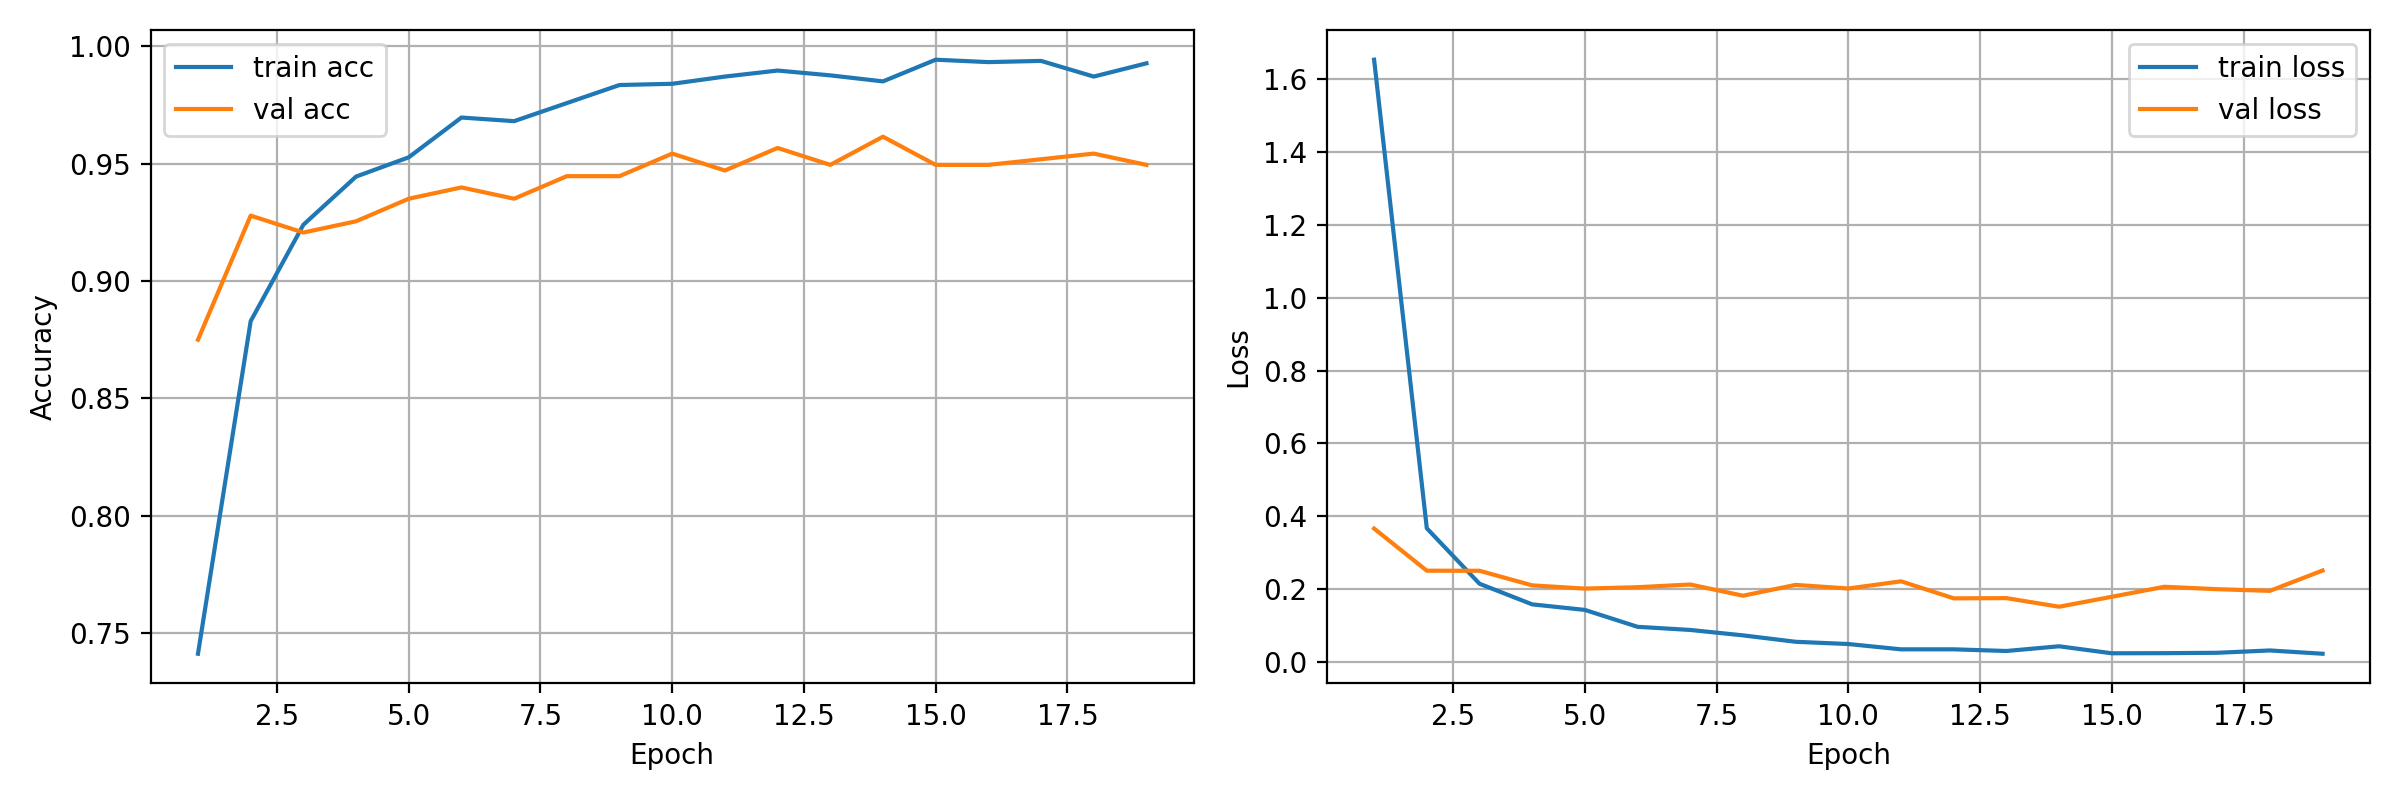

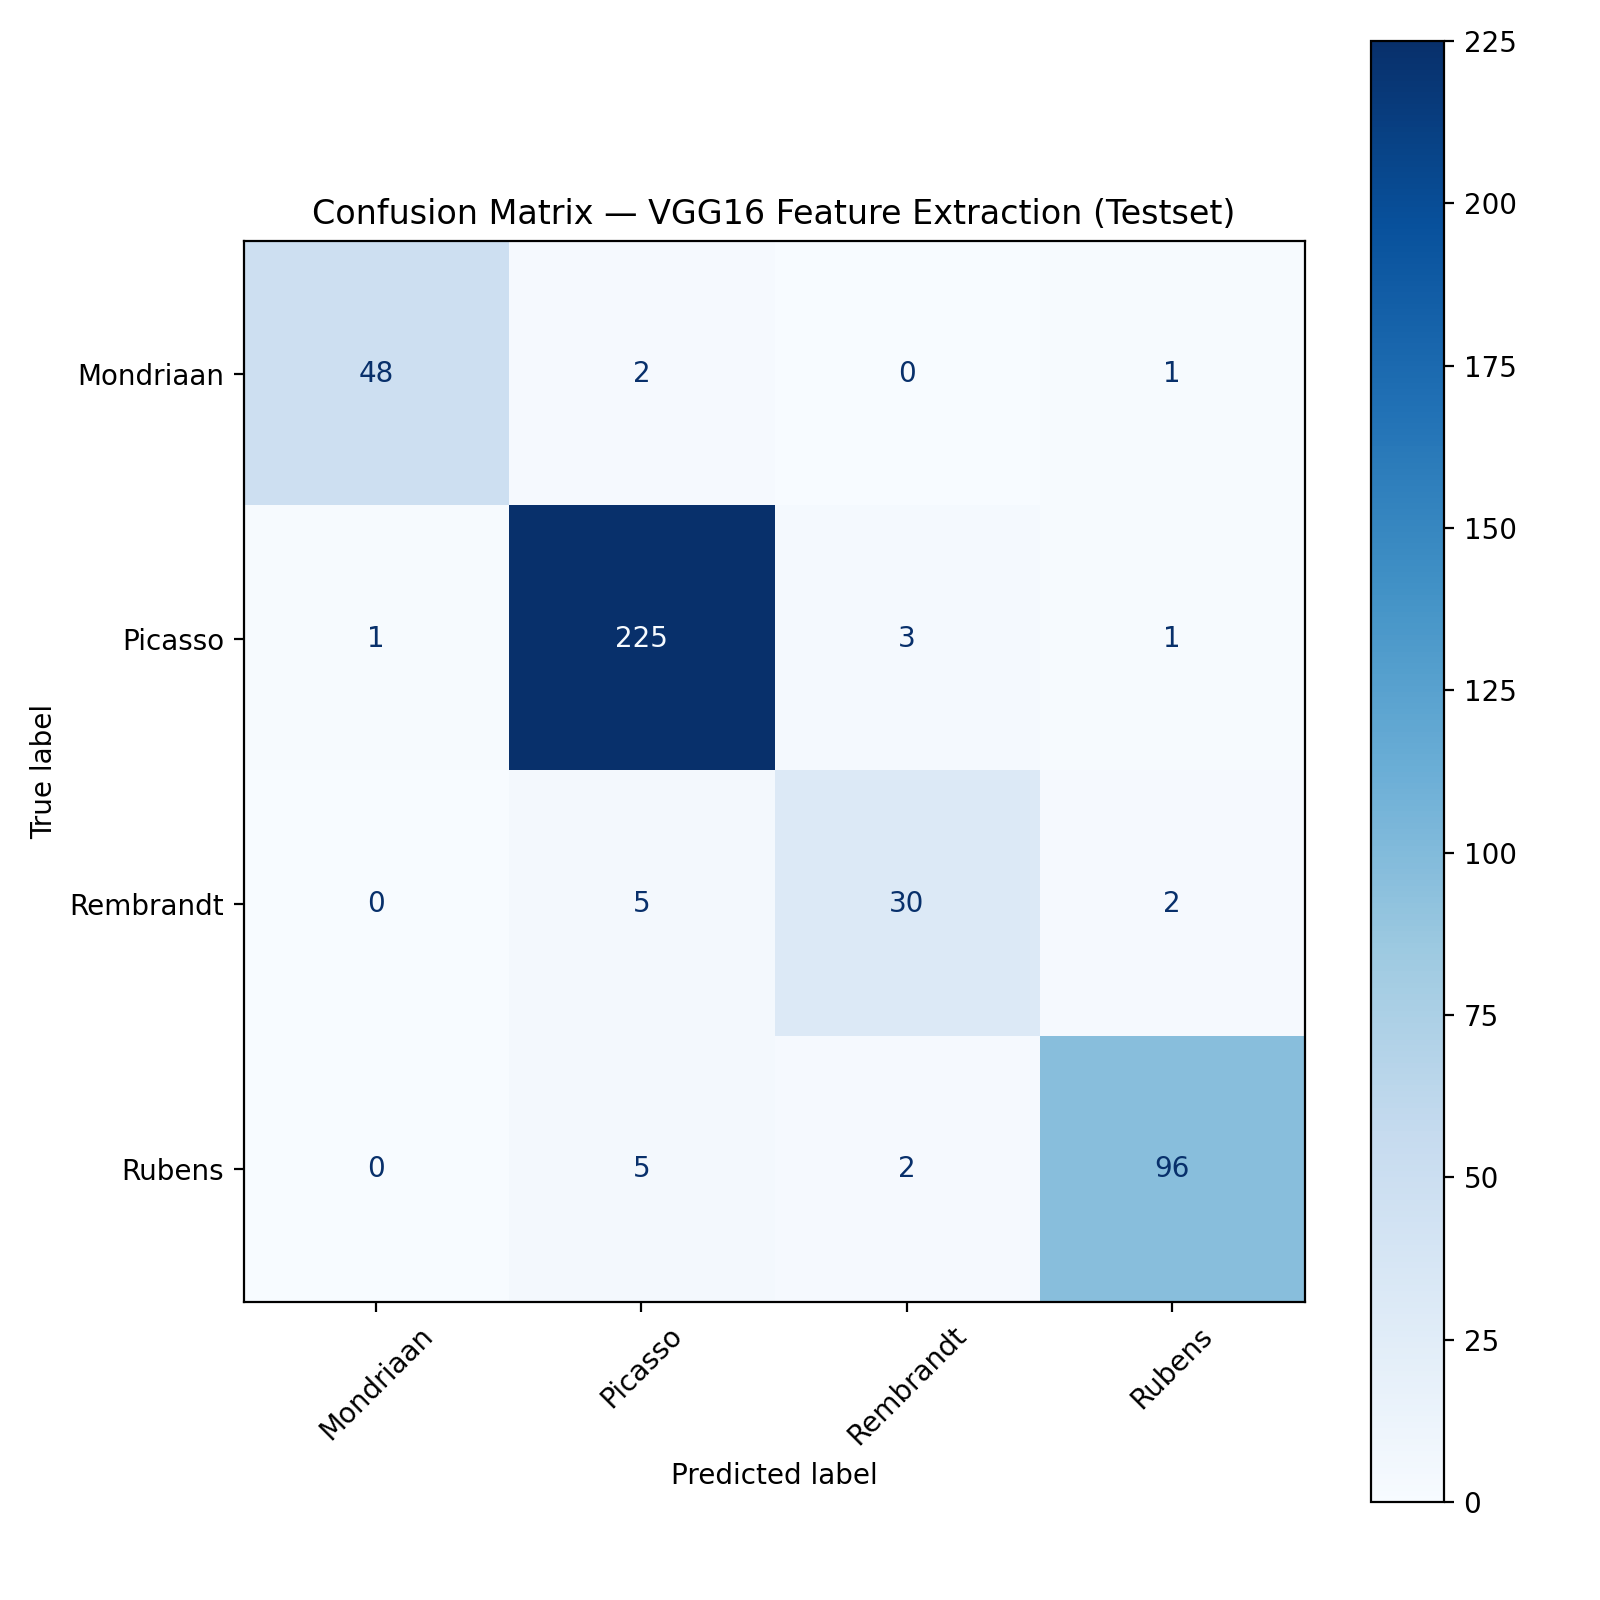

Best val_loss epoch: 14
  train_loss: 0.0426
  val_loss  : 0.1512
  train_acc : 0.9851
  val_acc   : 0.9615

Best val_accuracy epoch: 14
  train_loss: 0.0426
  val_loss  : 0.1512
  train_acc : 0.9851
  val_acc   : 0.9615

test_loss=0.23769143223762512
test_accuracy=0.9477434754371643


### Waarnemingen

De learning curves tonen een snelle convergentie met een beperkte kloof tussen training en validatie. De beste validatieprestaties worden bereikt rond epoch 14, met een **val_accuracy van 0.962** en een lage **val_loss van 0.151**, wat wijst op goede generalisatie.

Op de testset behaalt het model:

* **accuracy:** 0.948
* **macro F1-score:** 0.926

De confusion matrix toont dat alle klassen goed herkend worden. Mondriaan, Picasso en Rubens worden quasi foutloos geclassificeerd, terwijl Rembrandt relatief moeilijker blijft, vermoedelijk door het lagere aantal trainingsvoorbeelden.

### Vergelijking met simple ConvNet

In vergelijking met het simple ConvNet (test accuracy ~0.82, macro F1 ~0.77) levert VGG16 feature extraction een zeer duidelijke verbetering op. Dit benadrukt de meerwaarde van voorgetrainde convolutionele features ten opzichte van een model dat volledig vanaf nul wordt getraind.

### Conclusie

Feature extraction met een frozen VGG16 convolutionele basis resulteert in een sterke verbetering van zowel de algemene nauwkeurigheid als de prestaties op minderheidsklassen. Deze resultaten bevestigen dat een simple ConvNet onvoldoende is voor deze taak en dat transfer learning een essentieel onderdeel vormt van een performante oplossing. In de volgende stap onderzoeken we of data augmentation en finetuning van de bovenste VGG16-lagen de prestaties verder kunnen optimaliseren.

## 4.2 VGG16 met data augmentation

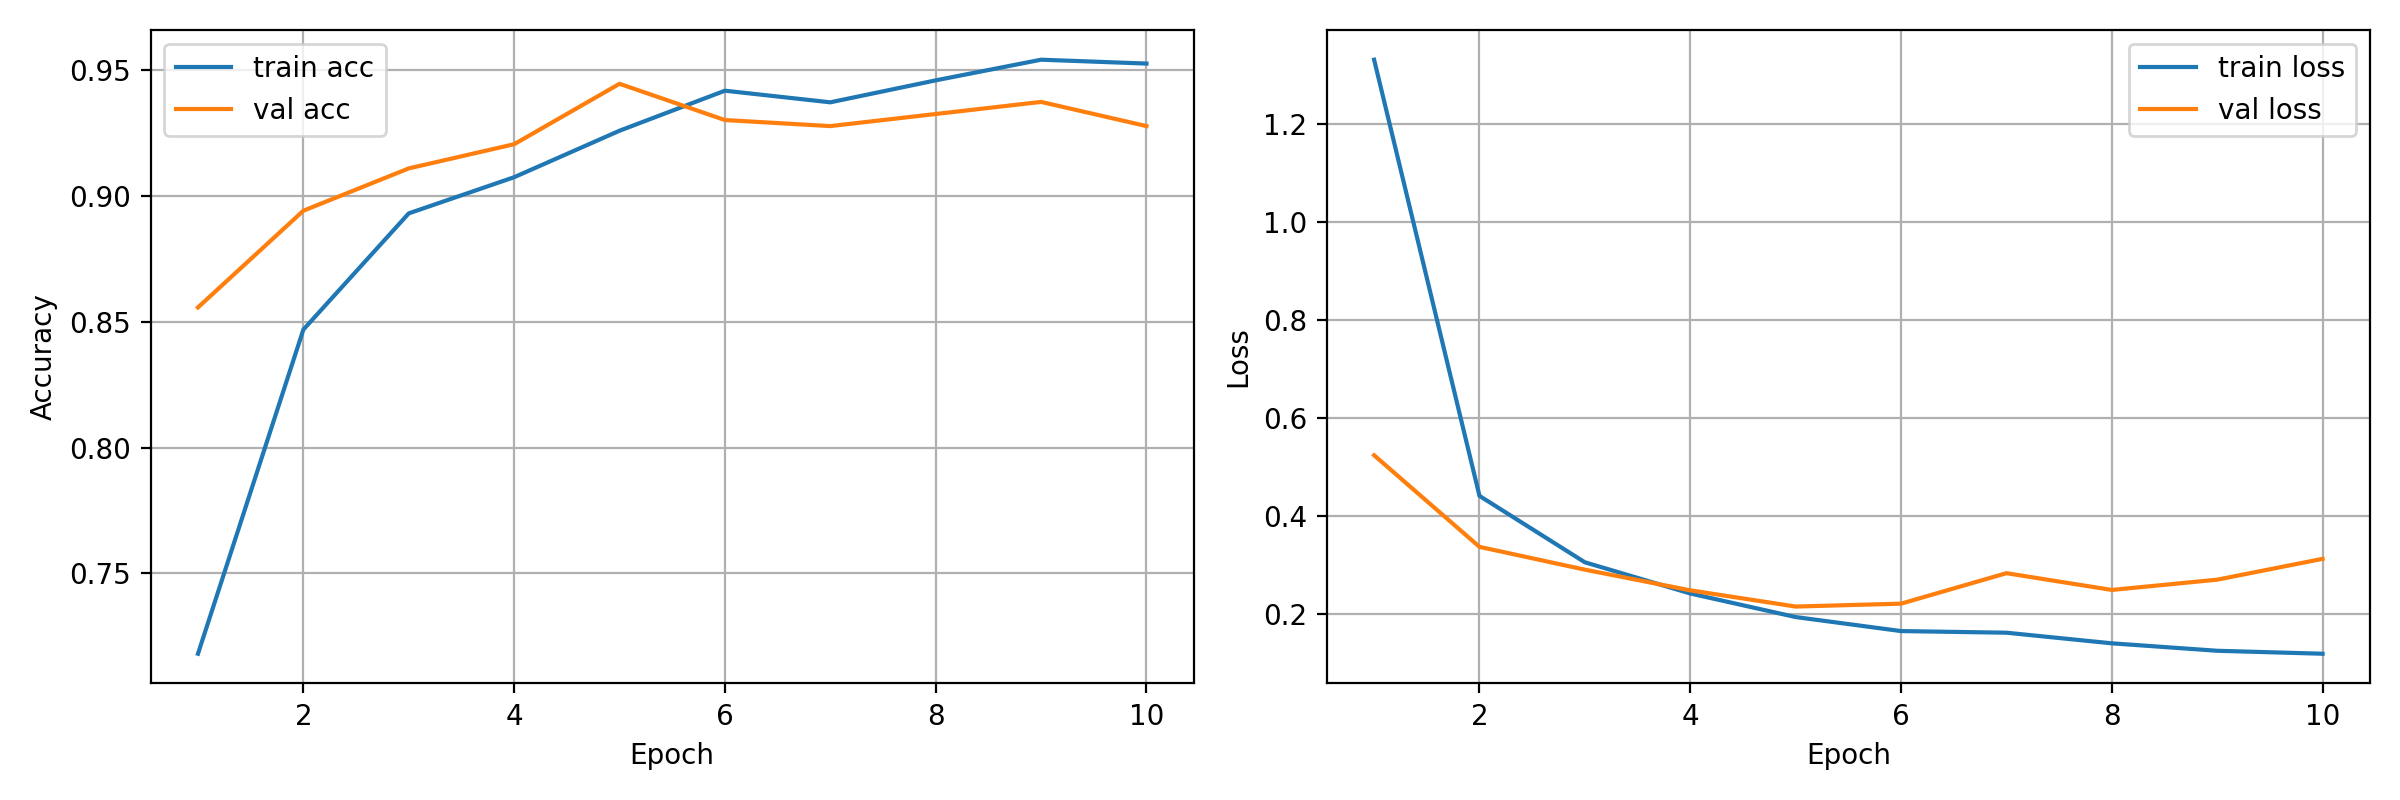

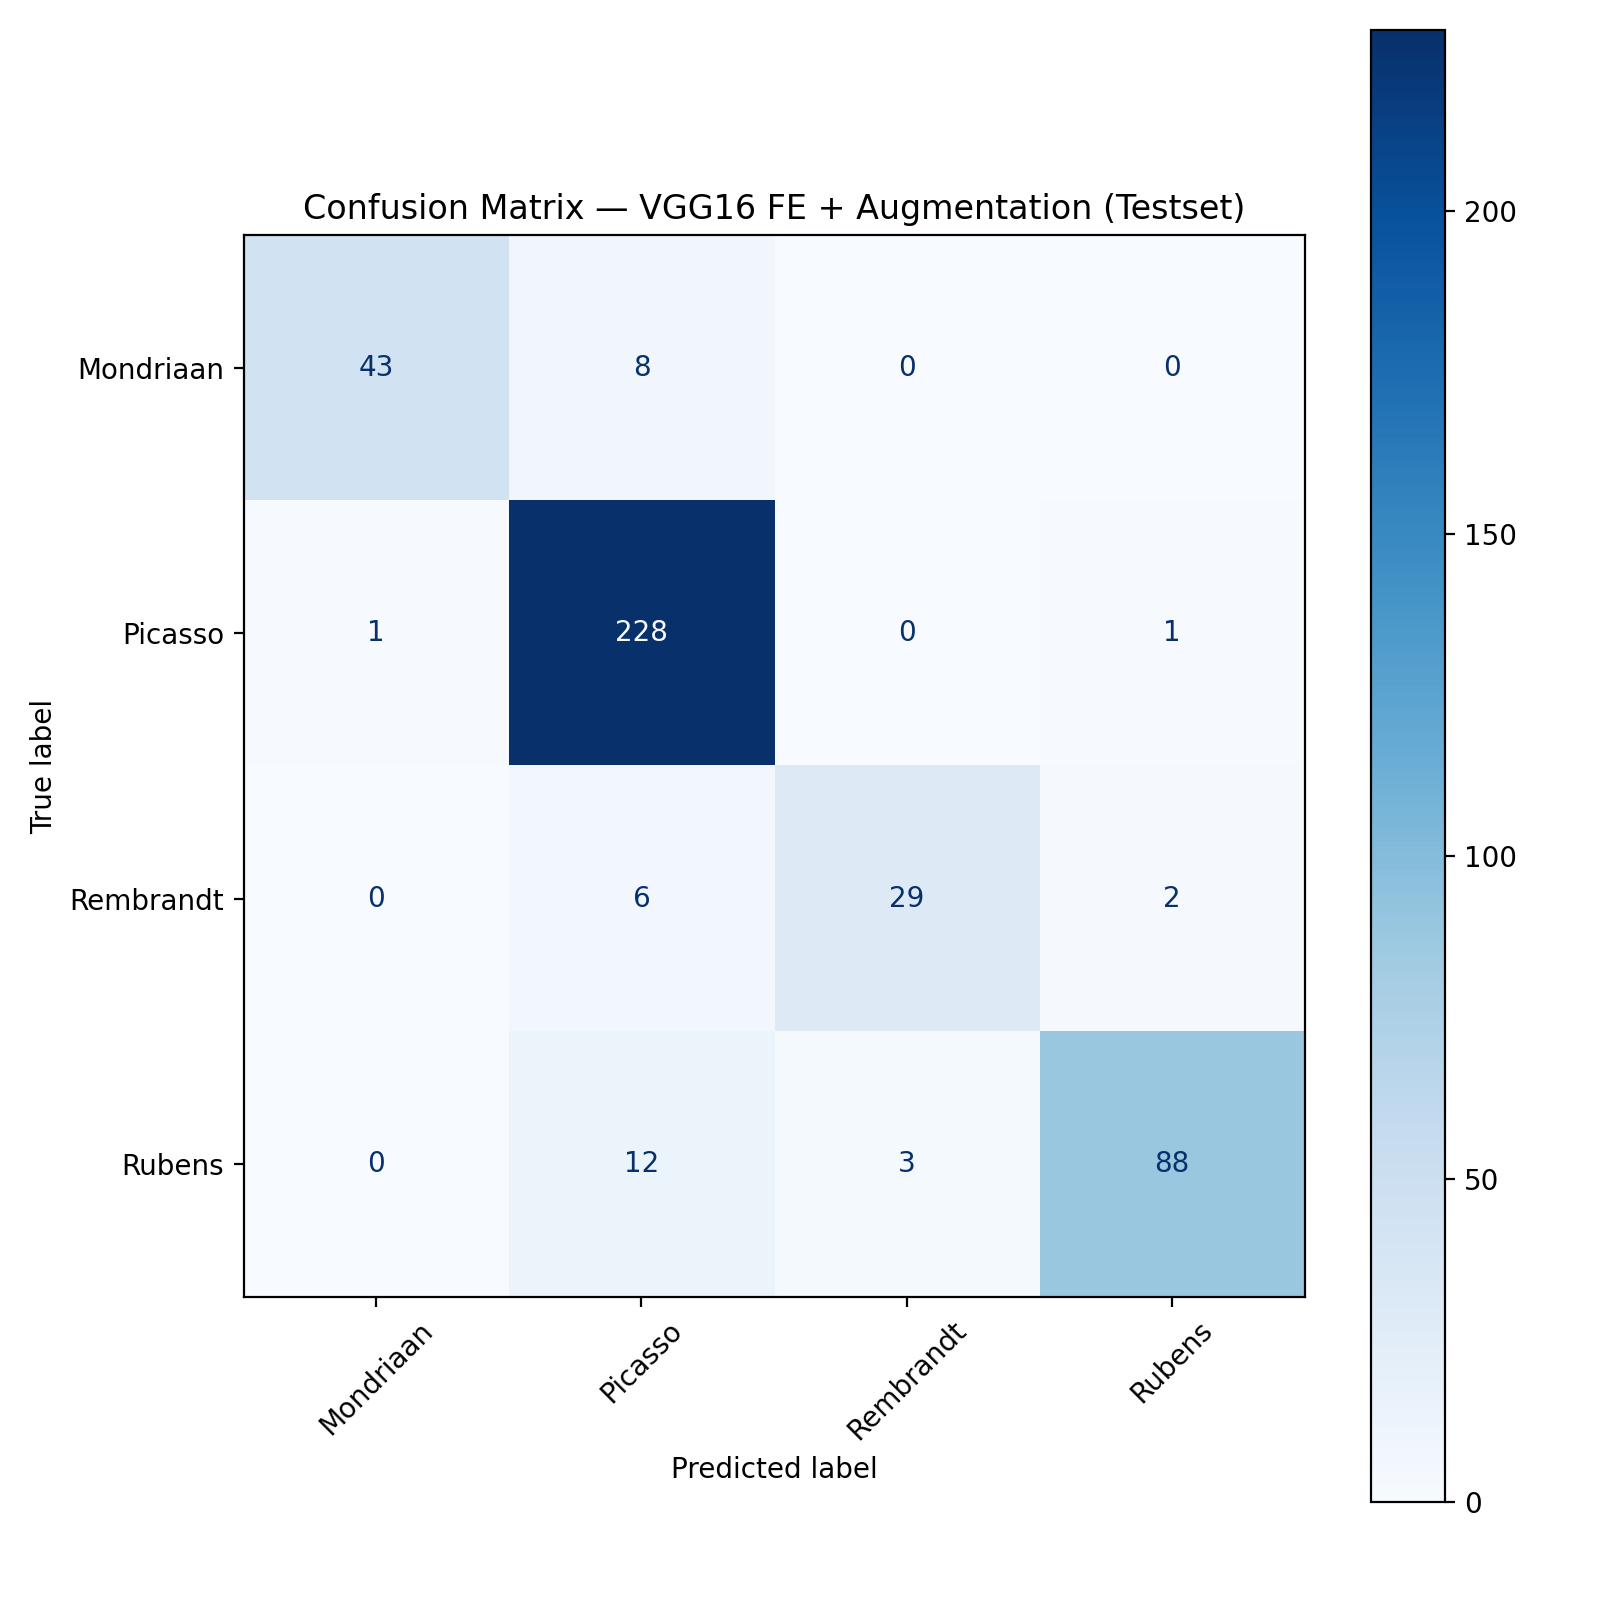

Best val_loss epoch: 5
  train_loss: 0.1948
  val_loss  : 0.2162
  train_acc : 0.9260
  val_acc   : 0.9447

Best val_accuracy epoch: 5
  train_loss: 0.1948
  val_loss  : 0.2162
  train_acc : 0.9260
  val_acc   : 0.9447

test_loss=0.29584813117980957
test_accuracy=0.9216151833534241


### Effect van data augmentation

Na het toepassen van data augmentation op het VGG16 feature-extraction model observeren we dat de prestaties **niet verbeteren** ten opzichte van het model zonder augmentation. Zowel de test accuracy als de macro F1-score liggen lager dan in het vorige experiment, ondanks het gebruik van dezelfde architectuur en trainingsopzet.

Dit resultaat is verklaarbaar doordat VGG16 reeds is voorgetraind op de grote en diverse ImageNet-dataset. De convolutionele filters zijn daardoor al robuust voor kleine variaties in vorm en compositie. Aangezien de conv base frozen blijft, generaliseert het model reeds goed naar het schilderijendomein, waardoor extra regularisatie via augmentation weinig effect heeft.

Daarnaast spelen bij schilderijen subtiele stilistische kenmerken een belangrijke rol, zoals penseelstreken, textuur en kleurgebruik. Sommige augmentaties (zoals rotatie of zoom) kunnen deze kenmerken deels verstoren, wat vooral zichtbaar is in een lichte daling van de prestaties voor minderheidsklassen.

Samengevat toont dit experiment aan dat data augmentation contextafhankelijk is en niet automatisch leidt tot betere prestaties. In dit geval biedt VGG16 feature extraction zonder augmentation de beste resultaten. In de volgende stap onderzoeken we of finetuning van de convolutionele lagen verdere verbetering kan opleveren.

## 4.3 VGG16 finetuning

### Finetuning van VGG16 (unfreeze block5)

#### Overgang en doel

Na feature extraction met een frozen VGG16 conv base onderzoeken we in deze stap of **finetuning** van de hogere convolutionele lagen kan leiden tot verdere prestatieverbetering. Hierbij worden enkel de lagen in `block5` van VGG16 trainbaar gemaakt, terwijl de eerdere lagen frozen blijven. Op deze manier kan het model zich voorzichtig aanpassen aan domeinspecifieke kenmerken van schilderijen, zonder de algemene ImageNet-features te verstoren.

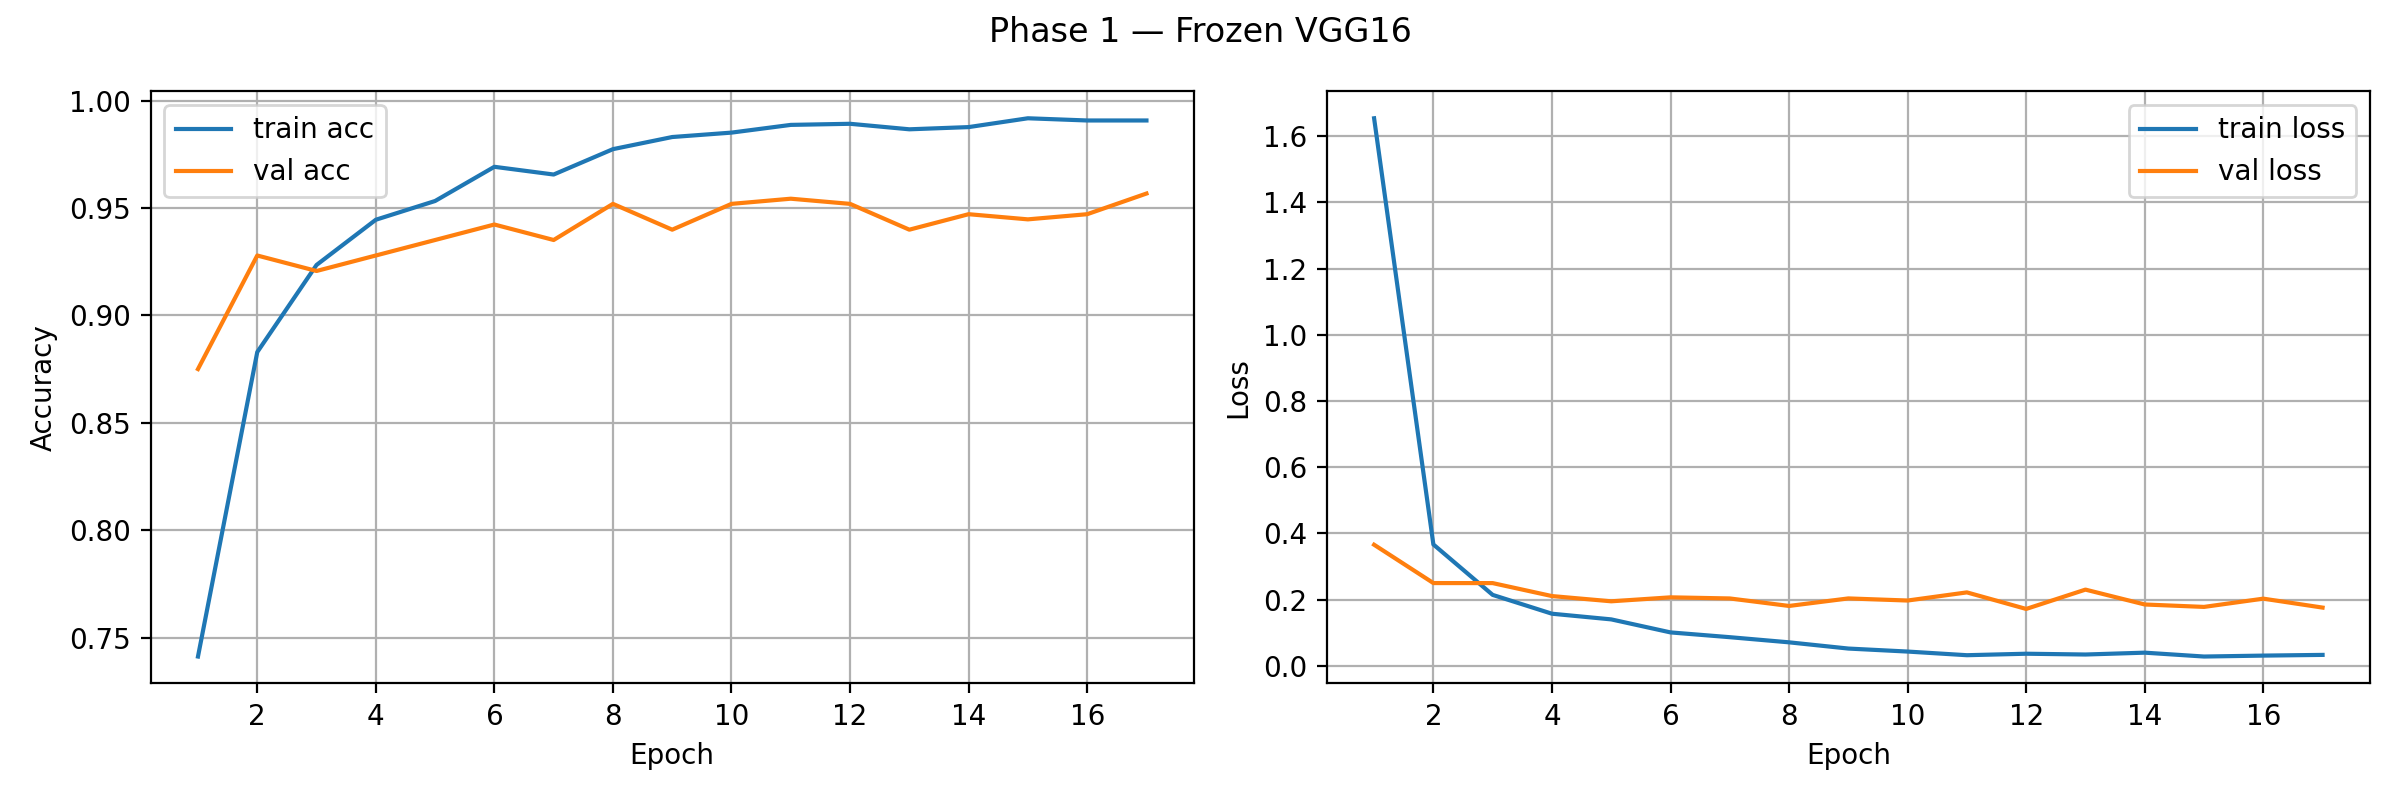

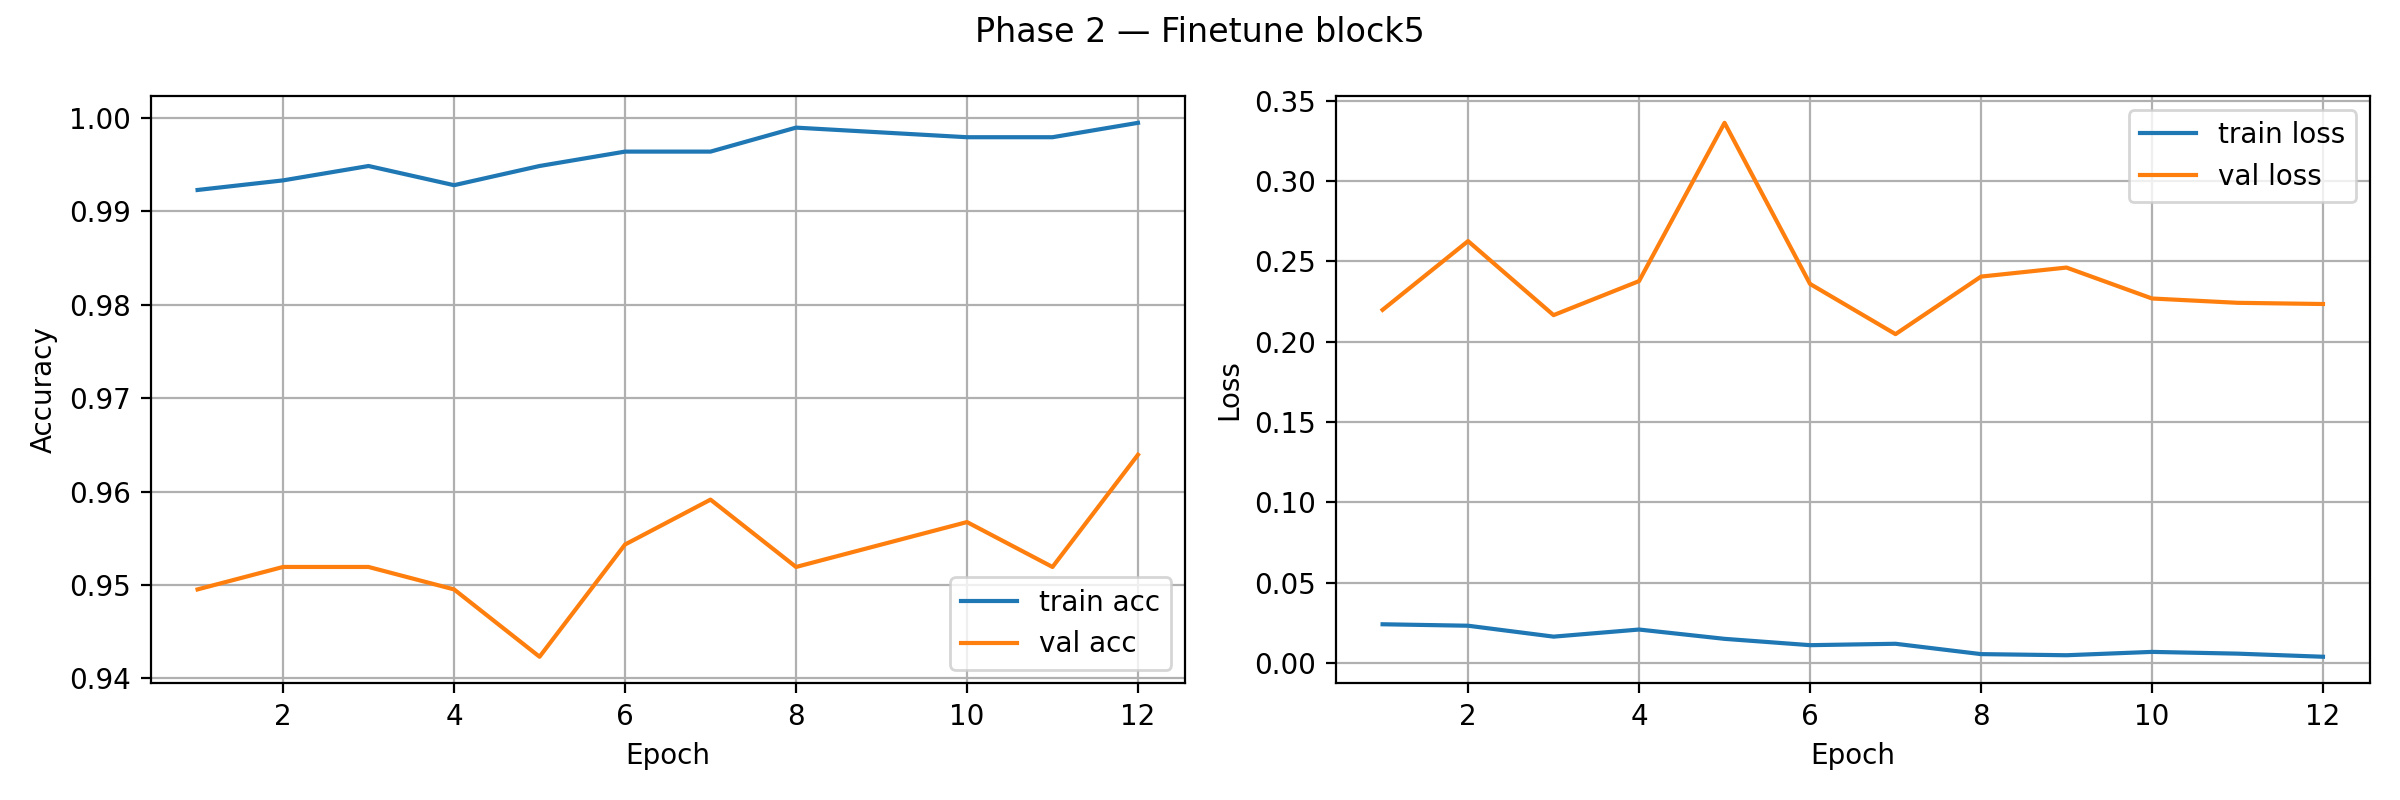

### Vergelijking Phase 1 vs Phase 2

In **Phase 1 (frozen VGG16)** behalen we reeds zeer sterke prestaties, met een validatie-accuracy rond **95–96%** en beperkte overfitting. De learning curves tonen een stabiele convergentie en een relatief kleine kloof tussen training en validatie.

In **Phase 2 (finetuning van block5)** stijgt de trainingsaccuracy verder tot bijna **100%**, terwijl ook de validatieprestaties licht verbeteren. De beste validatie-accuracy stijgt tot **96.4%**, en de test accuracy bereikt **95.2%**, wat hoger ligt dan bij feature extraction alleen.

### Analyse van de learning curves

De learning curves tijdens finetuning tonen:

* een zeer lage trainingsloss;
* een stabiele, licht fluctuerende validatieloss;
* een beperkte toename van overfitting, wat verwacht is bij finetuning.

Dit wijst erop dat het model extra flexibiliteit gebruikt om **hogere-level visuele patronen** beter af te stemmen op de schilderijen, zonder de generalisatie sterk te schaden.

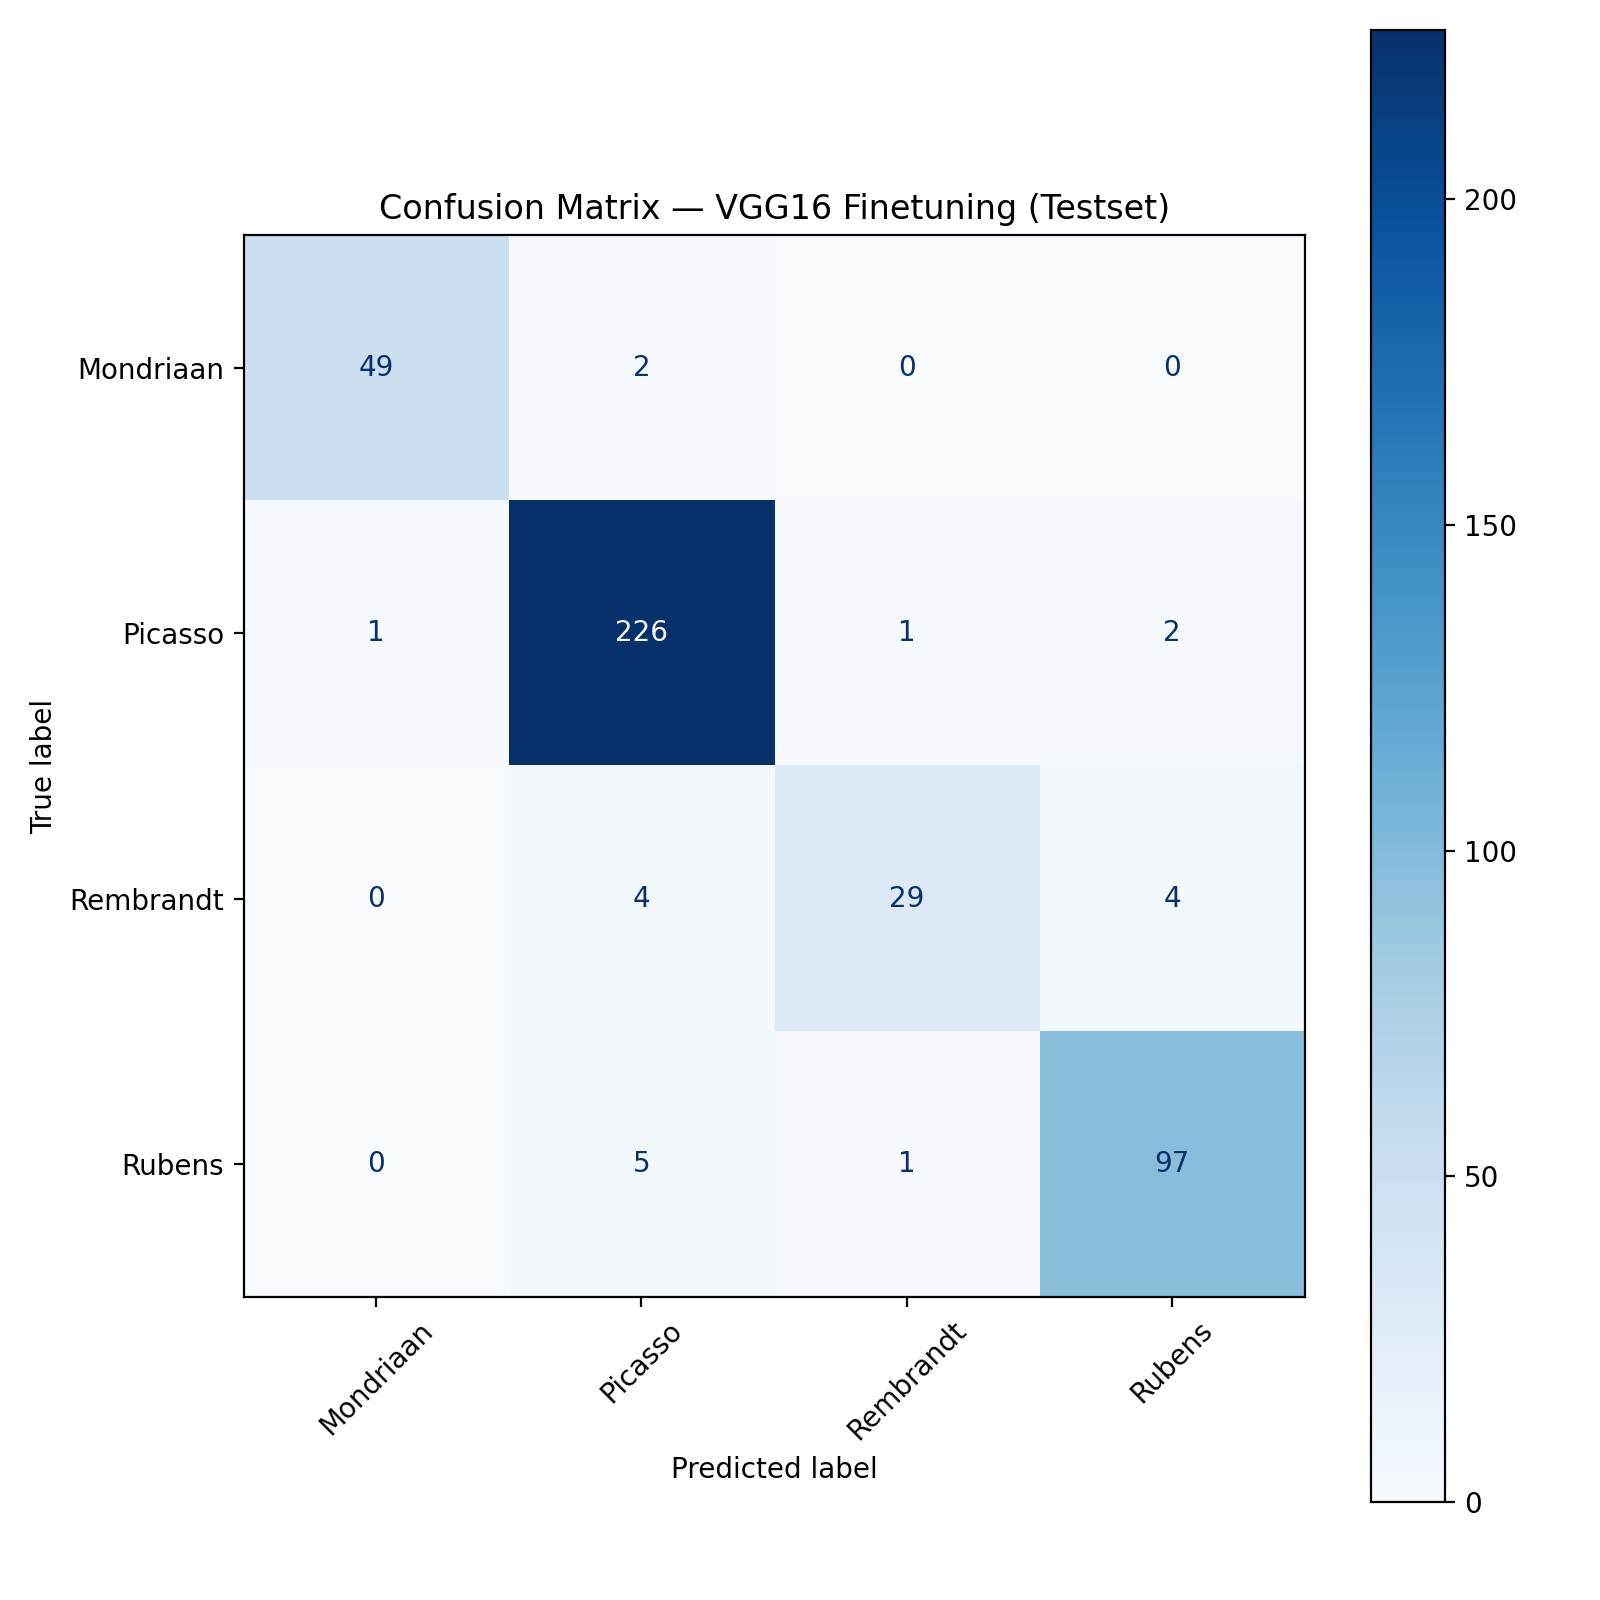

### Analyse van de confusion matrix

De confusion matrix laat zien dat:

* **Mondriaan**, **Picasso** en **Rubens** bijna perfect geclassificeerd worden;
* **Rembrandt** de moeilijkste klasse blijft, met een lagere recall.

Toch verbetert de macro F1-score tot **0.933**, wat aantoont dat finetuning vooral helpt om de prestaties over alle klassen heen beter in balans te brengen.


### Conclusie

Finetuning van de bovenste VGG16-lagen levert een **kleine maar consistente verbetering** op ten opzichte van feature extraction alleen. Dit bevestigt dat de ImageNet-voorgeleerde features reeds zeer krachtig zijn, maar dat beperkte aanpassing van hogere convolutionele lagen nuttig is om domeinspecifieke stijlkenmerken van schilderijen beter te modelleren.

## 4.4 VGG16 finetuning + class weights

Om de invloed van klasse-onbalans expliciet aan te pakken, werden class weights geïntroduceerd tijdens de training. Hierdoor worden fouten op ondervertegenwoordigde klassen zwaarder meegewogen in de lossfunctie.

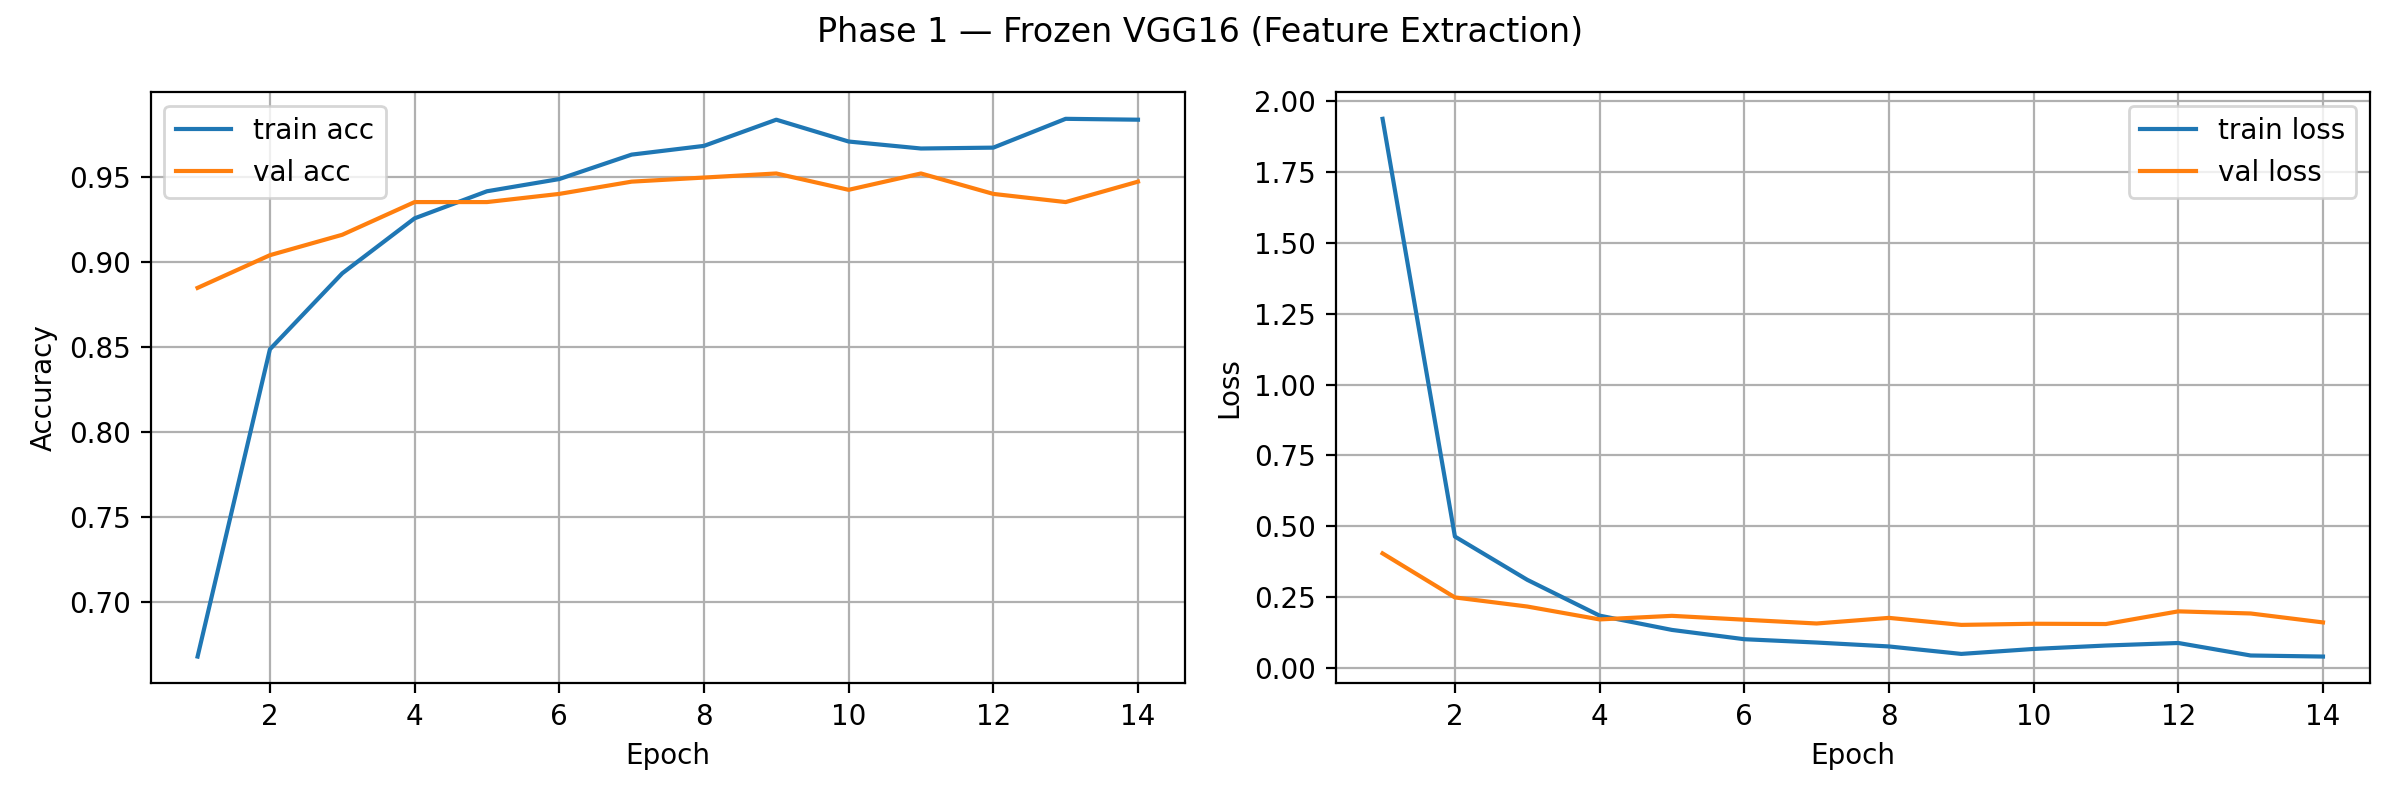

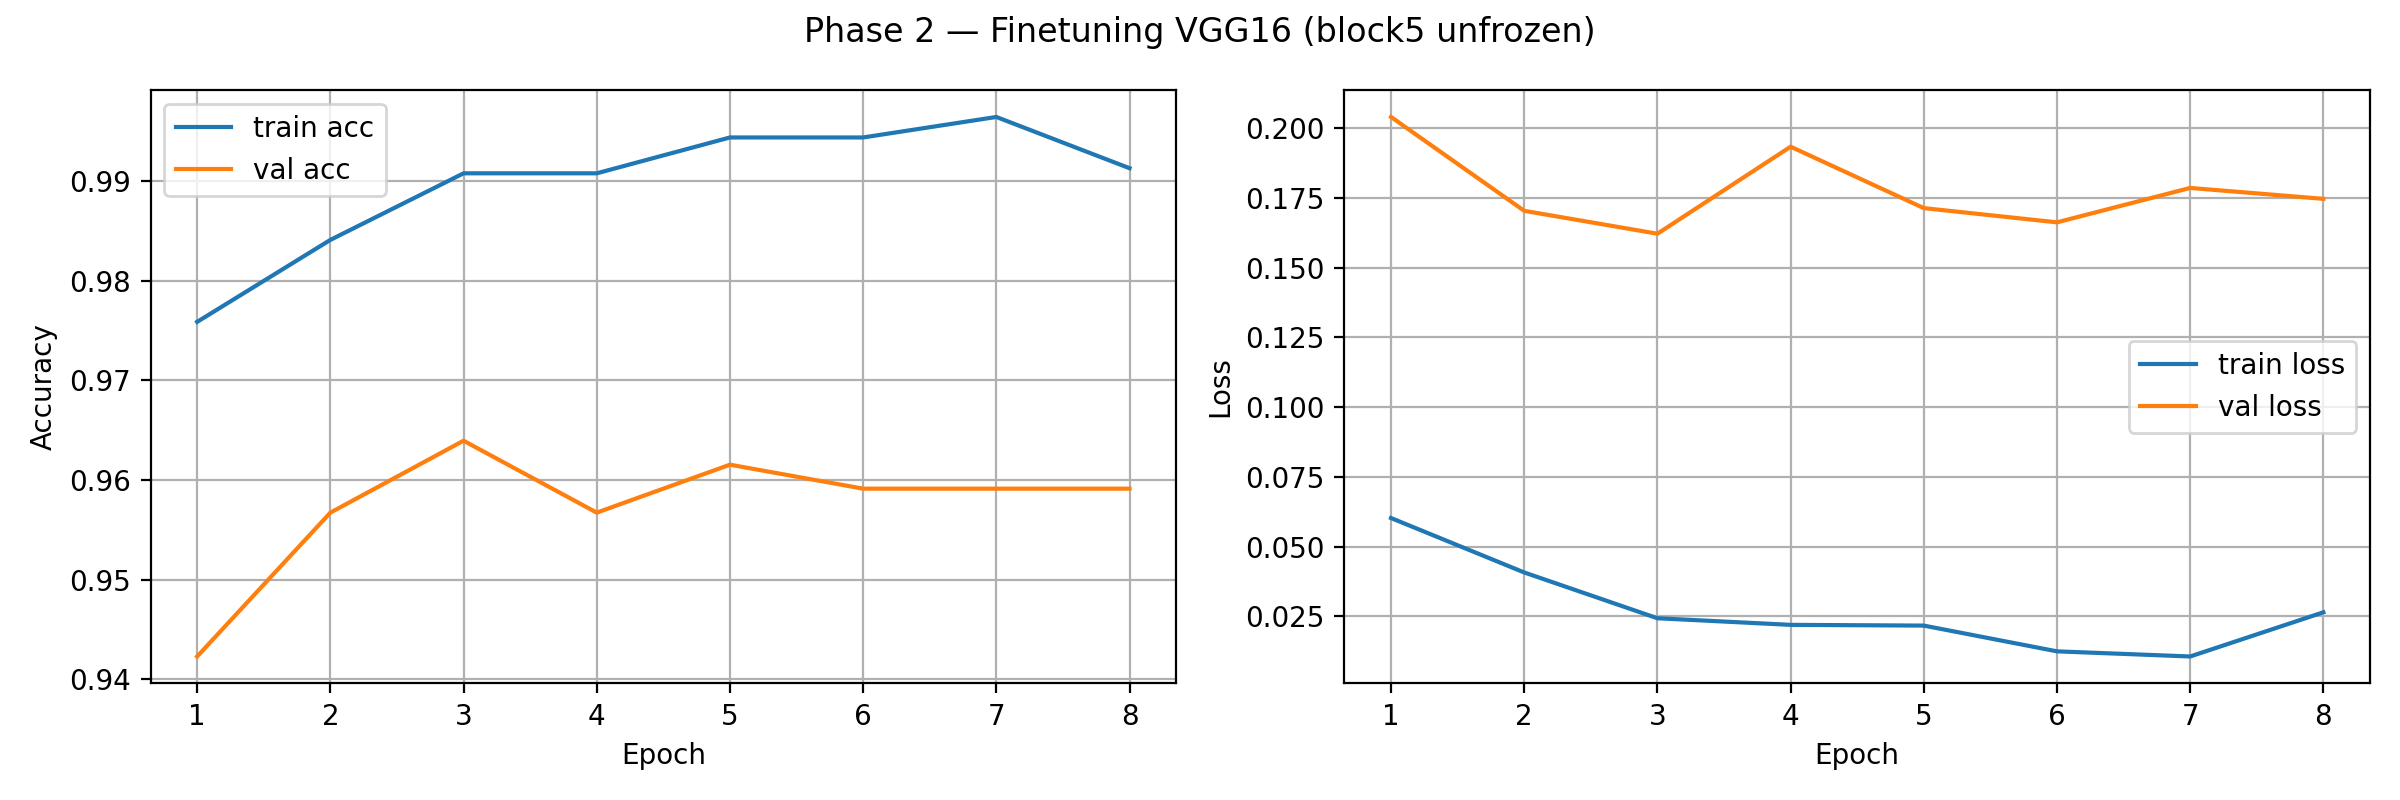

Best val_accuracy epoch: 3
  train_loss: 0.0243
  val_loss  : 0.1622
  train_acc : 0.9908
  val_acc   : 0.9639

test_loss=0.2071983367204666
test_accuracy=0.9572446346282959


Het trainingsproces blijft stabiel in zowel de feature-extractiefase als tijdens de fine-tuning van block5. Het beste validatieresultaat wordt reeds na enkele epochs bereikt, wat wijst op efficiënte benutting van de vooraf getrainde features.

De kloof tussen training- en validatie-accuracy blijft beperkt en de validatie-loss vertoont geen sterke stijging, wat suggereert dat overfitting onder controle blijft.

### Resultaten

- Beste validatie-accuracy: ~96.4%
- Test accuracy: ~95.7%

Hoewel de globale accuracy slechts licht stijgt ten opzichte van finetuning zonder class weights, is het effect duidelijk zichtbaar in de confusion matrix. De foutverdeling over de klassen is wat evenwichtiger.


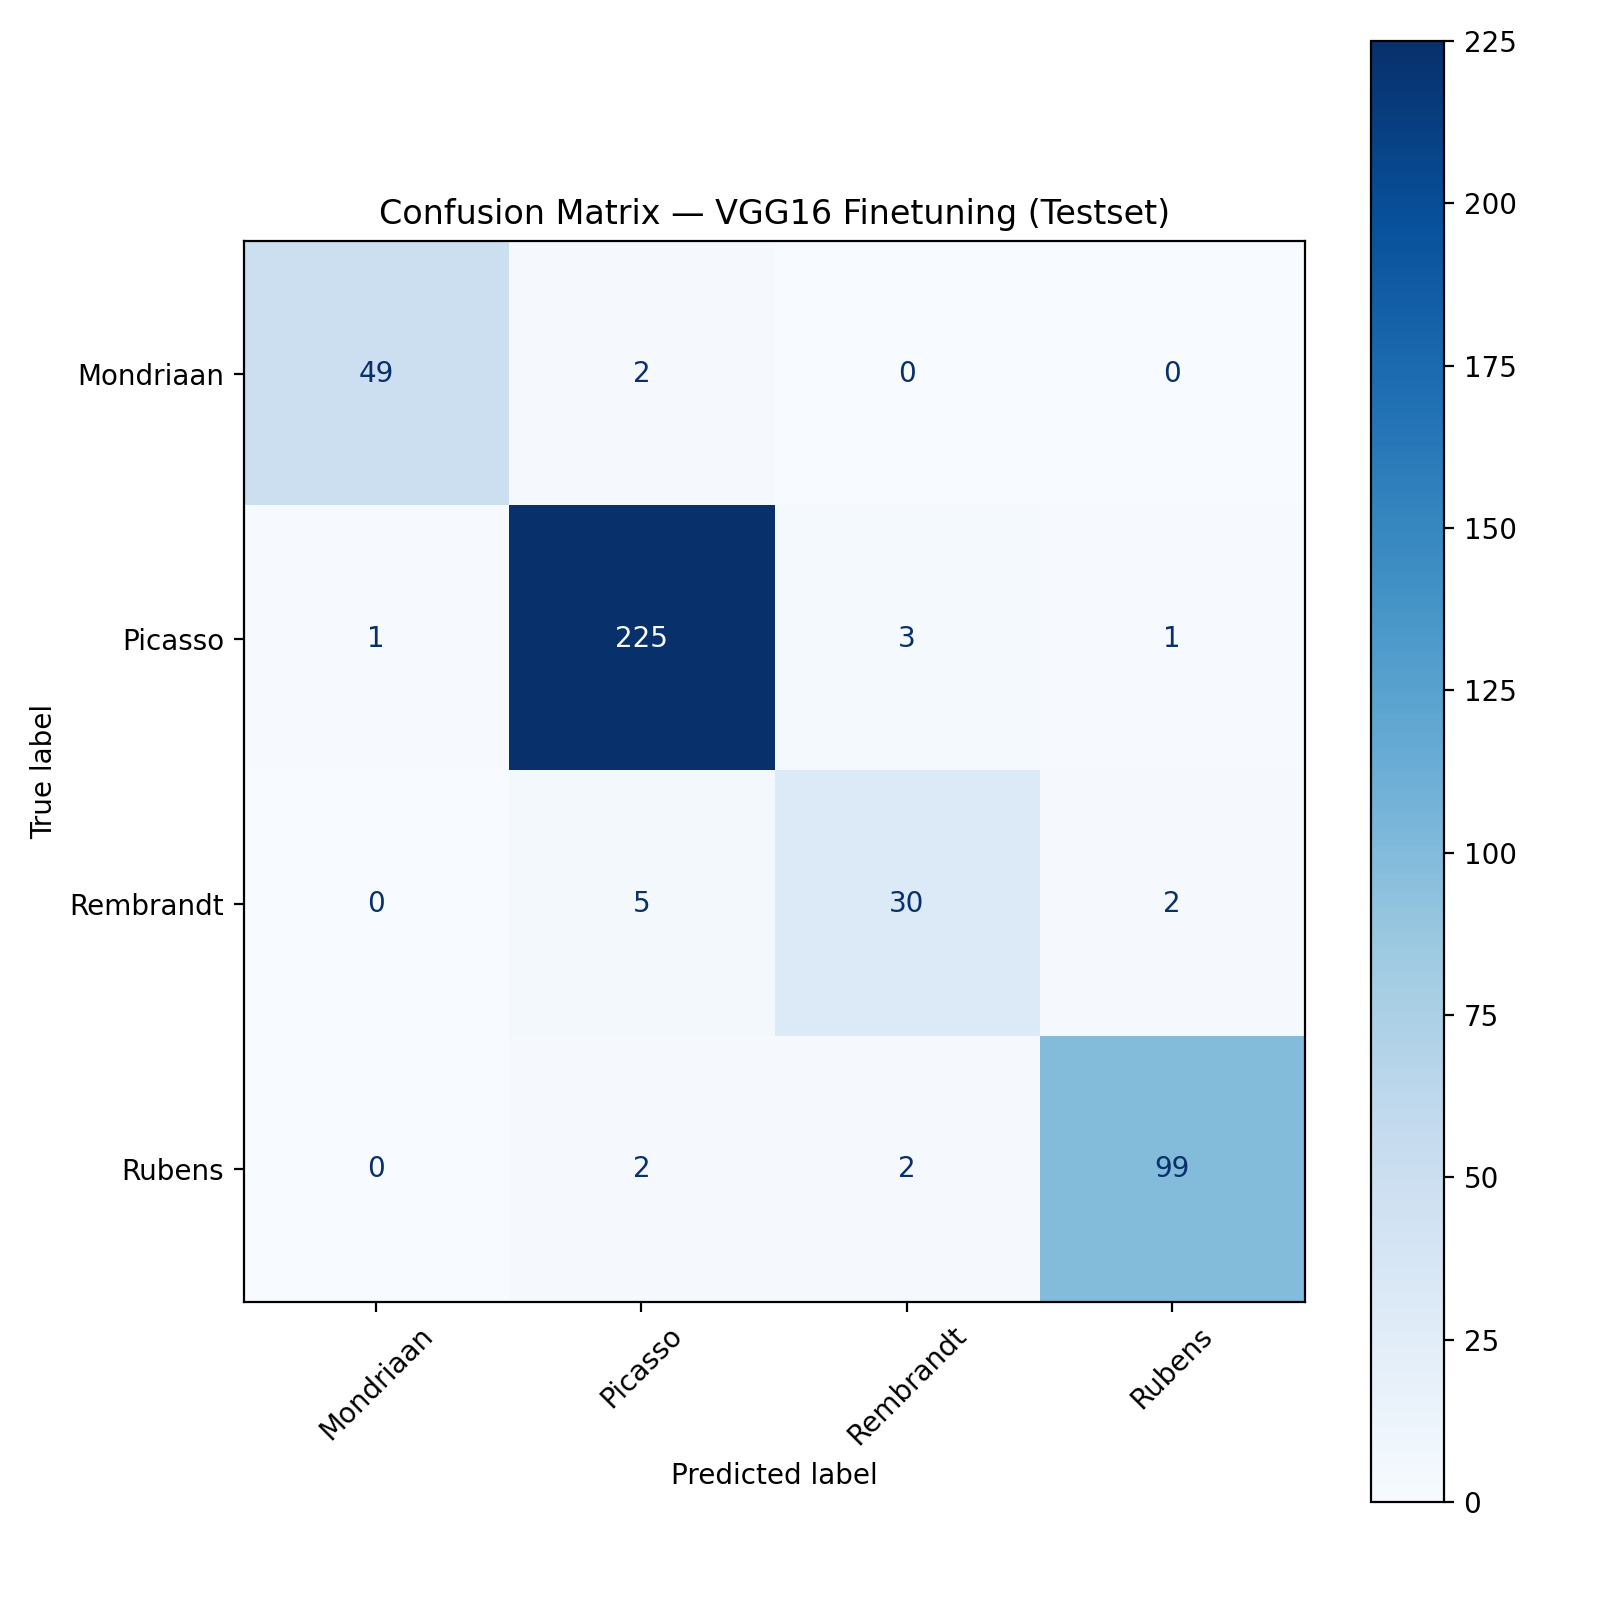

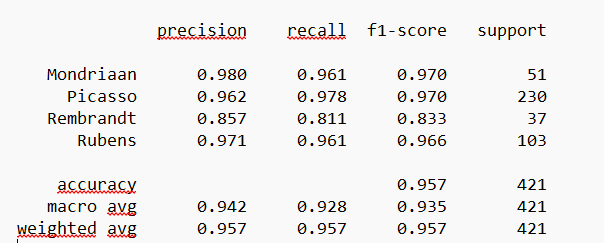

## Analyse van de confusion matrix en classification report

De confusion matrix van de testset toont aan dat het gefinetunede VGG16-model met class weights in staat is om alle vier de schilders met hoge nauwkeurigheid te onderscheiden. De meeste voorspellingen bevinden zich op de diagonaal, wat wijst op een hoge mate van correcte classificatie voor elke klasse.

### Prestatie per klasse

* **Mondriaan**
  Van de 51 testafbeeldingen worden er 49 correct geclassificeerd. Slechts twee afbeeldingen worden foutief als Picasso voorspeld. Dit resulteert in een hoge precision (0.980) en recall (0.961), wat aangeeft dat Mondriaan zowel betrouwbaar herkend wordt als zelden gemist wordt door het model.

* **Picasso**
  Als meerderheidklasse behaalt Picasso zeer sterke resultaten, met een recall van 0.978 en een f1-score van 0.970. Belangrijk is dat deze hoge prestatie niet ten koste gaat van de andere klassen, wat in eerdere experimenten zonder class weights wel het geval was.

* **Rembrandt**
  Rembrandt blijft de moeilijkste klasse, wat verklaarbaar is door het beperkte aantal trainingsvoorbeelden. Toch wordt 81.1% van de Rembrandt-afbeeldingen correct herkend. In eerdere modellen zonder class weights werd deze klasse vaker foutief als Picasso geclassificeerd. Het gebruik van class weights leidt hier tot een duidelijke verbetering, hoewel er nog ruimte is voor verdere optimalisatie.

* **Rubens**
  Rubens wordt zeer consistent herkend, met een recall van 0.961 en een f1-score van 0.966. De beperkte verwarring met andere klassen suggereert dat het model robuuste kenmerken heeft geleerd voor deze schilder.


## Interpretatie van macro- en weighted averages

De globale accuracy van **95.7%** bevestigt de hoge algemene prestatie van het model. Gezien de sterke klasse-onbalans is de **macro-averaged f1-score (0.935)** een belangrijkere maatstaf.

De relatief hoge macro f1-score toont aan dat het model **evenwichtige prestaties levert over alle klassen**, inclusief de minderheidsklassen. Het verschil tussen de macro average en de weighted average is beperkt, wat erop wijst dat het model niet langer sterk bevooroordeeld is richting de meerderheidklasse.


## Conclusie van deze analyse

De combinatie van transfer learning met VGG16, beperkte fine-tuning en het gebruik van class weights resulteert in een model dat niet alleen een hoge accuracy behaalt, maar ook **consistent en eerlijk presteert over alle klassen**.

In vergelijking met eerdere experimenten zonder class weights is vooral de herkenning van minderheidsklassen verbeterd, wat duidelijk zichtbaar is in zowel de confusion matrix als de macro-averaged prestaties. Deze resultaten bevestigen dat class weighting een effectieve strategie is om klasse-onbalans in beeldclassificatieproblemen te beperken.